In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
dask.config.set({"dataframe.shuffle.compression": 'Snappy'})
from dask.distributed import Client

In [3]:
 # magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

# Custom functions and tools 
import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
from gpmcmc import model_gp

In [4]:
%%time

gaia = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/gaia_dr3/gaia", 
                        columns=['ra', 'dec', 'parallax', 'parallax_over_error', 
                                'bp_rp', 'solution_id', 
                                'source_id', 
                                'pmra', 'pmra_error', 
                                'pmdec', 'pmdec_error', 
                                'parallax_error', 
                                'phot_g_mean_mag', 
                                'l', 'b', 'non_single_star', 
                                'classprob_dsc_combmod_galaxy', 
                                'classprob_dsc_combmod_star', 
                                 'in_qso_candidates'])

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 40.1 s, sys: 4.63 s, total: 44.7 s
Wall time: 44.7 s


In [6]:
from distributed import Client
client = Client(n_workers=15, threads_per_worker=1)

In [7]:
client

<Client: 'tcp://127.0.0.1:39937' processes=15 threads=15, memory=0.98 TiB>

## TAPE

In [8]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper
pd.options.mode.chained_assignment = None

# Initialize an Ensemble
ens = Ensemble(client=client)
ens.client_info()

<Client: 'tcp://127.0.0.1:39937' processes=15 threads=15, memory=0.98 TiB>

In [9]:
%%time
# load pre-saved FG sample
_sample_hips = lsdb.read_hipscat("/astro/users/atzanida/epyc/ssd/users/atzanida/tmp/data_files/fg_sample")

CPU times: user 1.79 s, sys: 370 ms, total: 2.16 s
Wall time: 1.81 s


In [7]:
%%time
_sample_hips._ddf.shape[0].compute()

CPU times: user 21.5 s, sys: 3.8 s, total: 25.3 s
Wall time: 34.3 s


4833834

In [10]:
%%time
_sources = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 2min 11s, sys: 8.74 s, total: 2min 20s
Wall time: 2min 15s


In [11]:
_sources

Dask DataFrame Structure:
                     ra_gaia_andy_fg_dwarfs dec_gaia_andy_fg_dwarfs parallax_gaia_andy_fg_dwarfs parallax_over_error_gaia_andy_fg_dwarfs bp_rp_gaia_andy_fg_dwarfs solution_id_gaia_andy_fg_dwarfs source_id_gaia_andy_fg_dwarfs pmra_gaia_andy_fg_dwarfs pmra_error_gaia_andy_fg_dwarfs pmdec_gaia_andy_fg_dwarfs pmdec_error_gaia_andy_fg_dwarfs parallax_error_gaia_andy_fg_dwarfs phot_g_mean_mag_gaia_andy_fg_dwarfs l_gaia_andy_fg_dwarfs b_gaia_andy_fg_dwarfs non_single_star_gaia_andy_fg_dwarfs classprob_dsc_combmod_galaxy_gaia_andy_fg_dwarfs classprob_dsc_combmod_star_gaia_andy_fg_dwarfs in_qso_candidates_gaia_andy_fg_dwarfs teff_gspphot_gaia_andy_fg_dwarfs teff_gspphot_upper_gaia_andy_fg_dwarfs teff_gspphot_lower_gaia_andy_fg_dwarfs logg_gspphot_gaia_andy_fg_dwarfs logg_gspphot_lower_gaia_andy_fg_dwarfs logg_gspphot_upper_gaia_andy_fg_dwarfs mh_gspphot_gaia_andy_fg_dwarfs mh_gspphot_lower_gaia_andy_fg_dwarfs mh_gspphot_upper_gaia_andy_fg_dwarfs distance_gspphot_gaia_andy_fg_dwarfs distance_gspphot_lower_gaia_andy_fg_dwarfs distance_gspphot_upper_gaia_andy_fg_dwarfs azero_gspphot_gaia_andy_fg_dwarfs azero_gspphot_lower_gaia_andy_fg_dwarfs azero_gspphot_upper_gaia_andy_fg_dwarfs ag_gspphot_gaia_andy_fg_dwarfs ebpminrp_gspphot_gaia_andy_fg_dwarfs ebpminrp_gspphot_lower_gaia_andy_fg_dwarfs ebpminrp_gspphot_upper_gaia_andy_fg_dwarfs Norder_gaia_andy_fg_dwarfs Npix_gaia_andy_fg_dwarfs Dir_gaia_andy_fg_dwarfs ps1_objid_ztf_dr14_andy_fg_dwarfs ra_ztf_dr14_andy_fg_dwarfs dec_ztf_dr14_andy_fg_dwarfs ps1_gMeanPSFMag_ztf_dr14_andy_fg_dwarfs ps1_rMeanPSFMag_ztf_dr14_andy_fg_dwarfs ps1_iMeanPSFMag_ztf_dr14_andy_fg_dwarfs nobs_g_ztf_dr14_andy_fg_dwarfs nobs_r_ztf_dr14_andy_fg_dwarfs nobs_i_ztf_dr14_andy_fg_dwarfs mean_mag_g_ztf_dr14_andy_fg_dwarfs mean_mag_r_ztf_dr14_andy_fg_dwarfs mean_mag_i_ztf_dr14_andy_fg_dwarfs Norder_ztf_dr14_andy_fg_dwarfs Dir_ztf_dr14_andy_fg_dwarfs Npix_ztf_dr14_andy_fg_dwarfs _DIST_andy_fg_dwarfs Norder_andy_fg_dwarfs Dir_andy_fg_dwarfs Npix_andy_fg_dwarfs index_ztf_source ps1_objid_ztf_source ra_ztf_source dec_ztf_source ps1_gMeanPSFMag_ztf_source ps1_rMeanPSFMag_ztf_source ps1_iMeanPSFMag_ztf_source nobs_g_ztf_source nobs_r_ztf_source nobs_i_ztf_source mean_mag_g_ztf_source mean_mag_r_ztf_source mean_mag_i_ztf_source catflags_ztf_source fieldID_ztf_source mag_ztf_source magerr_ztf_source mjd_ztf_source rcID_ztf_source band_ztf_source Norder_ztf_source Dir_ztf_source Npix_ztf_source
npartitions=287241                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [12]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

## Test Case gr combined

In [15]:
%%time
lc = ens.source.loc[391062914590572544]
lc = lc.compute()

Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x7f6e967d5840>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/utils_perf.py", line 176, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterrupt: 
2024-04-07 12:39:14,547 - distributed.nanny - ERROR - Worker process died unexpectedly
2024-04-07 12:39:14,548 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2024-04-07 12:39:14,548 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2024-04-07 12:39:14,549 - distributed.

2024-04-07 12:39:32,385 - distributed.nanny - WARNING - Restarting worker
2024-04-07 12:39:32,390 - distributed.nanny - WARNING - Restarting worker
2024-04-07 12:39:32,401 - distributed.nanny - WARNING - Restarting worker
2024-04-07 12:39:32,417 - distributed.nanny - WARNING - Restarting worker
2024-04-07 12:39:32,432 - distributed.nanny - WARNING - Restarting worker
2024-04-07 12:39:32,447 - distributed.nanny - WARNING - Restarting worker
2024-04-07 12:39:32,459 - distributed.nanny - WARNING - Restarting worker
2024-04-07 12:39:32,471 - distributed.nanny - WARNING - Restarting worker
2024-04-07 12:39:32,482 - distributed.nanny - WARNING - Restarting worker
2024-04-07 12:39:32,492 - distributed.nanny - WARNING - Restarting worker
2024-04-07 12:39:32,509 - distributed.nanny - WARNING - Restarting worker
2024-04-07 12:39:32,523 - distributed.nanny - WARNING - Restarting worker
2024-04-07 12:39:32,530 - distributed.nanny - WARNING - Restarting worker
2024-04-07 12:39:32,541 - distributed.

KeyboardInterrupt: 

In [26]:
%%time
# know dipper
# working example 4078931319013244928
# good example: 16721355873452032

lc = ens.source.loc[391062914590572544]
lc = lc.compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 28.8 s, sys: 9.79 s, total: 38.6 s
Wall time: 42 s


In [539]:
lc['fieldID_ztf_source']

_hipscat_index
391062914590572544    704
391062914590572544    704
391062914590572544    703
391062914590572544    704
391062914590572544    704
                     ... 
391062914590572544    703
391062914590572544    703
391062914590572544    703
391062914590572544    703
391062914590572544    703
Name: fieldID_ztf_source, Length: 1852, dtype: int16

In [27]:
time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='r', flag_good=0)

timeg, magg, magerrg = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='g', flag_good=0)

In [28]:
plt.errorbar(time, mag, magerr, fmt='-o', color='Crimson')
plt.errorbar(timeg, magg, magerrg, fmt='-o', color='green')

loc = 59219.26408

plt.xlabel("Time [MJD]")
plt.ylabel("Magnitude")

plt.axvline(loc)
plt.xlim(loc-245, loc+245)

plt.ylim(plt.ylim()[::-1])

(19.145585345849394, 15.457600017264486)

In [29]:
plt.figure(figsize=(3,3))
plt.errorbar(time, mag-np.median(mag), magerr, fmt='.', color='Crimson')
plt.errorbar(timeg, magg-np.median(magg), magerrg, fmt='.', color='green')
plt.axvline(loc)
plt.xlabel("Time [MJD]")
plt.ylabel("Normalized Mag")

Text(0, 0.5, 'Normalized Mag')

In [90]:
print (evaluate(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'], lc['ra_ztf_source'].values[0], 
        lc['dec_ztf_source'].values[0]))

Nphot                           142.000000
biweight_scale                    0.335685
frac_above_2_sigma                0.056338
Ndips                             2.000000
rate                              0.001240
chi2dof                           1.000001
ADF_const                        -5.466265
ADF_const_trend                  -5.443084
ADF_pval_const                    0.000002
ADF_pval_const_trend              0.000030
skew                              1.168783
kurtosis                          2.387342
mad                               0.198906
stetson_i                     37773.757812
stetson_j                      1371.026489
stetson_k                         0.776532
invNeumann                        6.796211
best_dip_power                    4.229616
best_dip_time_loc             59219.264080
best_dip_start                59203.244370
best_dip_end                  59227.265810
best_dip_dt                       0.000000
best_dip_ndet                     5.000000
best_dip_sc

## Full Search

In [16]:
# define my cols 
column_names = ['Nphot',
    'biweight_scale',
    'frac_above_2_sigma',
    'Ndips',
    'rate',
    'chi2dof',
    'ADF_const',
    'ADF_const_trend',
    'ADF_pval_const',
    'ADF_pval_const_trend',
    'skew', 
    'kurtosis',
    'mad',
    'stetson_i',
    'stetson_j',
    'stetson_k',
    'invNeumann',
    'best_dip_power',
    'best_dip_time_loc',
    'best_dip_start',
    'best_dip_end',
    'best_dip_dt',
    'best_dip_ndet',
    'best_dip_score',
    'left_error',
    'right_error',
    'chi_square_gp',
    'gp_fun',
    'gp_status',
    'separation_btw_peaks',
    'closest_bright_star_arcsec',
    'closest_bright_star_mag',
    'closest_star_arcsec',
    'closest_star_mag',
    'density_arcsec2']

# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=column_names, dtype=float)

In [ ]:
%%time
# apply calc_biweight function
calc_ = ens.batch(
    evaluate,
    'mjd_ztf_source', 'mag_ztf_source', 
    'magerr_ztf_source', 'catflags_ztf_source',
    'band_ztf_source', 'ra_ztf_source', 
    'dec_ztf_source',
    meta=my_meta,
    use_map=True)

In [93]:
%%time
ens.object.join(calc_).update_ensemble()

CPU times: user 9.01 s, sys: 1.29 s, total: 10.3 s
Wall time: 9.73 s


In [ ]:
%%time
#full_table = ens.object.compute() # full table compute
# ran on Feb 14 10:45PM

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 144.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-02-15 01:30:05,255 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "

2024-02-15 01:31:44,223 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:31:44,695 - tornado.application - ERROR - Exception in call

2024-02-15 01:31:48,825 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:31:49,360 - tornado.application - ERROR - Exception in call

2024-02-15 01:31:53,359 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:31:53,740 - tornado.application - ERROR - Exception in call

2024-02-15 01:31:57,867 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:31:58,347 - tornado.application - ERROR - Exception in call

2024-02-15 01:32:02,307 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:32:02,723 - tornado.application - ERROR - Exception in call

2024-02-15 01:32:07,058 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:32:07,858 - tornado.application - ERROR - Exception in call

2024-02-15 01:32:11,833 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:32:12,336 - tornado.application - ERROR - Exception in call

2024-02-15 01:32:16,370 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:32:16,837 - tornado.application - ERROR - Exception in call

2024-02-15 01:32:20,865 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:32:21,475 - tornado.application - ERROR - Exception in call

2024-02-15 01:32:26,367 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:32:26,769 - tornado.application - ERROR - Exception in call

2024-02-15 01:32:30,815 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:32:31,325 - tornado.application - ERROR - Exception in call

2024-02-15 01:32:35,272 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:32:35,809 - tornado.application - ERROR - Exception in call

2024-02-15 01:32:39,864 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:32:40,351 - tornado.application - ERROR - Exception in call

2024-02-15 01:32:44,329 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:32:44,767 - tornado.application - ERROR - Exception in call

2024-02-15 01:32:48,789 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:32:49,308 - tornado.application - ERROR - Exception in call

2024-02-15 01:32:53,313 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:32:53,832 - tornado.application - ERROR - Exception in call

2024-02-15 01:32:57,823 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:32:58,268 - tornado.application - ERROR - Exception in call

2024-02-15 01:33:02,364 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:33:02,783 - tornado.application - ERROR - Exception in call

2024-02-15 01:33:06,791 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:33:07,369 - tornado.application - ERROR - Exception in call

2024-02-15 01:33:11,258 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:33:11,777 - tornado.application - ERROR - Exception in call

2024-02-15 01:33:15,840 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:33:16,437 - tornado.application - ERROR - Exception in call

2024-02-15 01:33:20,466 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2024-02-15 01:33:20,859 - tornado.application - ERROR - Exception in call

2024-02-15 01:33:25,180 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f1375365150>>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/tornado/websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-pa

In [359]:
full_table.head(1)

ra_gaia  dec_gaia  parallax_gaia  parallax_over_error_gaia  \
_hipscat_index                                                                 
10595126476800  44.920804  0.146074       0.379842                  5.828582   

                bp_rp_gaia     solution_id_gaia  source_id_gaia  pmra_gaia  \
_hipscat_index                                                               
10595126476800    0.895802  1636148068921376768   5291399870976   1.774002   

                pmra_error_gaia  pmdec_gaia  ...  right_error  chi_square_gp  \
_hipscat_index                               ...                               
10595126476800         0.071176   -3.285704  ...          NaN            NaN   

                gp_fun  gp_status  separation_btw_peaks  \
_hipscat_index                                            
10595126476800     NaN        NaN                   NaN   

                closest_bright_star_arcsec  closest_bright_star_mag  \
_hipscat_index                                                        
10595126476800                         NaN                      NaN   

                closest_star_arcsec  closest_star_mag  density_arcsec2  
_hipscat_index                                                          
10595126476800                  NaN               NaN              NaN  

[1 rows x 95 columns]

In [100]:
print (f"Number of computed sources: {len(full_table)}")

Number of computed sources: 4833834


In [104]:
_ = plt.hist(full_table['invNeumann'], bins=(250))
plt.yscale('log')

In [132]:
full_table.keys()

Index(['ra_gaia', 'dec_gaia', 'parallax_gaia', 'parallax_over_error_gaia',
       'bp_rp_gaia', 'solution_id_gaia', 'source_id_gaia', 'pmra_gaia',
       'pmra_error_gaia', 'pmdec_gaia', 'pmdec_error_gaia',
       'parallax_error_gaia', 'phot_g_mean_mag_gaia', 'l_gaia', 'b_gaia',
       'non_single_star_gaia', 'classprob_dsc_combmod_galaxy_gaia',
       'classprob_dsc_combmod_star_gaia', 'in_qso_candidates_gaia',
       'teff_gspphot_gaia', 'teff_gspphot_upper_gaia',
       'teff_gspphot_lower_gaia', 'logg_gspphot_gaia',
       'logg_gspphot_lower_gaia', 'logg_gspphot_upper_gaia', 'mh_gspphot_gaia',
       'mh_gspphot_lower_gaia', 'mh_gspphot_upper_gaia',
       'distance_gspphot_gaia', 'distance_gspphot_lower_gaia',
       'distance_gspphot_upper_gaia', 'azero_gspphot_gaia',
       'azero_gspphot_lower_gaia', 'azero_gspphot_upper_gaia',
       'ag_gspphot_gaia', 'ebpminrp_gspphot_gaia',
       'ebpminrp_gspphot_lower_gaia', 'ebpminrp_gspphot_upper_gaia',
       'Norder_gaia', 'Npix_ga

In [319]:
q = (full_table['skew']>1.2) &\
(full_table['invNeumann']>1.5) 

In [320]:
len(full_table[q])

666

In [358]:
from matplotlib import cm
from matplotlib.colors import Normalize

# Assuming full_table is your DataFrame
# q is the condition for filtering data, as per your original scatter plot

# Define bin size and edges
bin_size = 250
teff_min = full_table[q]['teff_gspphot_gaia'].min()
teff_max = full_table[q]['teff_gspphot_gaia'].max()
teff_bins = np.arange(teff_min, teff_max + bin_size, bin_size)

# Bin the data using numpy
teff_bin_column = np.digitize(full_table[q]['teff_gspphot_gaia'], bins=teff_bins)

# Choose a colormap
cmap = cm.get_cmap('rainbow', len(teff_bins)-1)  # Use 'rainbow' colormap with the number of bins - 1 colors
norm = Normalize(vmin=min(teff_bins), vmax=max(teff_bins))  # Normalize the colors

# Create box plot with different colors for each box
plt.figure(figsize=(15, 6))
boxes = plt.boxplot([group['invNeumann'] for _, group in full_table[q].groupby(teff_bin_column)],
                   labels=[f'{int(b)}-{int(b + bin_size)} K' for b in teff_bins[:-1]],
                   patch_artist=True)  # Enable patch_artist for color customization

# Set box colors
for box, color in zip(boxes['boxes'], cmap(norm(teff_bins[:-1]))):
    box.set_facecolor(color)

# Set labels and title
plt.xlabel('Effective Temperature (K)')
plt.ylabel('invNeumann')

plt.ylim(1.2, 10)

/tmp/ipykernel_111856/3822025523.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', len(teff_bins)-1)  # Use 'rainbow' colormap with the number of bins - 1 colors


(1.2, 10.0)

In [259]:
full_table[(full_table['best_dip_power']>7) & \
           (full_table['best_dip_ndet']>3) & \
          (full_table['biweight_scale']<0.01) &\
          (full_table['mad']<0.01) & \
          (full_table['kurtosis']>1)]

ra_gaia   dec_gaia  parallax_gaia  \
_hipscat_index                                             
393869823529975808   89.442633  45.669346       0.389508   
6263867854949449728  98.624869   6.122442       1.911580   
6464787778444984320  74.040409   2.828513       0.374071   

                     parallax_over_error_gaia  bp_rp_gaia  \
_hipscat_index                                              
393869823529975808                    7.46683    1.002990   
6263867854949449728                  87.12648    0.988071   
6464787778444984320                   8.46357    0.678895   

                        solution_id_gaia       source_id_gaia  pmra_gaia  \
_hipscat_index                                                             
393869823529975808   1636148068921376768   196934906337656320  -0.406976   
6263867854949449728  1636148068921376768  3131933930851287424   4.709170   
6464787778444984320  1636148068921376768  3232393868735878656   0.935609   

                     pmra_error_gaia  pmdec_gaia  ...  right_error  \
_hipscat_index                                    ...                
393869823529975808          0.050115   -0.751985  ...     0.000000   
6263867854949449728         0.025768  -11.619381  ...     9.753351   
6464787778444984320         0.056996    0.979257  ...    49.519550   

                     chi_square_gp  gp_fun     gp_status  \
_hipscat_index                                             
393869823529975808       16.838324     1.0  7.274561e-07   
6263867854949449728      16.273417     1.0  6.889644e-07   
6464787778444984320      16.792336     1.0  5.229836e-07   

                     separation_btw_peaks  closest_bright_star_arcsec  \
_hipscat_index                                                          
393869823529975808                4.97285                         0.0   
6263867854949449728              -1.93401                         0.0   
6464787778444984320             -19.00815                         0.0   

                     closest_bright_star_mag  closest_star_arcsec  \
_hipscat_index                                                      
393869823529975808                       0.0                  0.0   
6263867854949449728                      0.0                  0.0   
6464787778444984320                      0.0                  0.0   

                     closest_star_mag  density_arcsec2  
_hipscat_index                                          
393869823529975808                0.0              0.0  
6263867854949449728               0.0              0.0  
6464787778444984320               0.0              0.0  

[3 rows x 95 columns]

# READ COMPUTED CATALOG

In [4]:
%%time
# Stored computed features
fg = dask.dataframe.read_parquet("/epyc/ssd/users/atzanida/tmp/fg_full_feb16.parquet").compute()

CPU times: user 6.14 s, sys: 24.6 s, total: 30.7 s
Wall time: 10.3 s


In [52]:
fg.keys()

Index(['ra_gaia', 'dec_gaia', 'parallax_gaia', 'parallax_over_error_gaia',
       'bp_rp_gaia', 'solution_id_gaia', 'source_id_gaia', 'pmra_gaia',
       'pmra_error_gaia', 'pmdec_gaia', 'pmdec_error_gaia',
       'parallax_error_gaia', 'phot_g_mean_mag_gaia', 'l_gaia', 'b_gaia',
       'non_single_star_gaia', 'classprob_dsc_combmod_galaxy_gaia',
       'classprob_dsc_combmod_star_gaia', 'in_qso_candidates_gaia',
       'teff_gspphot_gaia', 'teff_gspphot_upper_gaia',
       'teff_gspphot_lower_gaia', 'logg_gspphot_gaia',
       'logg_gspphot_lower_gaia', 'logg_gspphot_upper_gaia', 'mh_gspphot_gaia',
       'mh_gspphot_lower_gaia', 'mh_gspphot_upper_gaia',
       'distance_gspphot_gaia', 'distance_gspphot_lower_gaia',
       'distance_gspphot_upper_gaia', 'azero_gspphot_gaia',
       'azero_gspphot_lower_gaia', 'azero_gspphot_upper_gaia',
       'ag_gspphot_gaia', 'ebpminrp_gspphot_gaia',
       'ebpminrp_gspphot_lower_gaia', 'ebpminrp_gspphot_upper_gaia',
       'Norder_gaia', 'Npix_ga

Text(0.5, 0, '(r-i)')

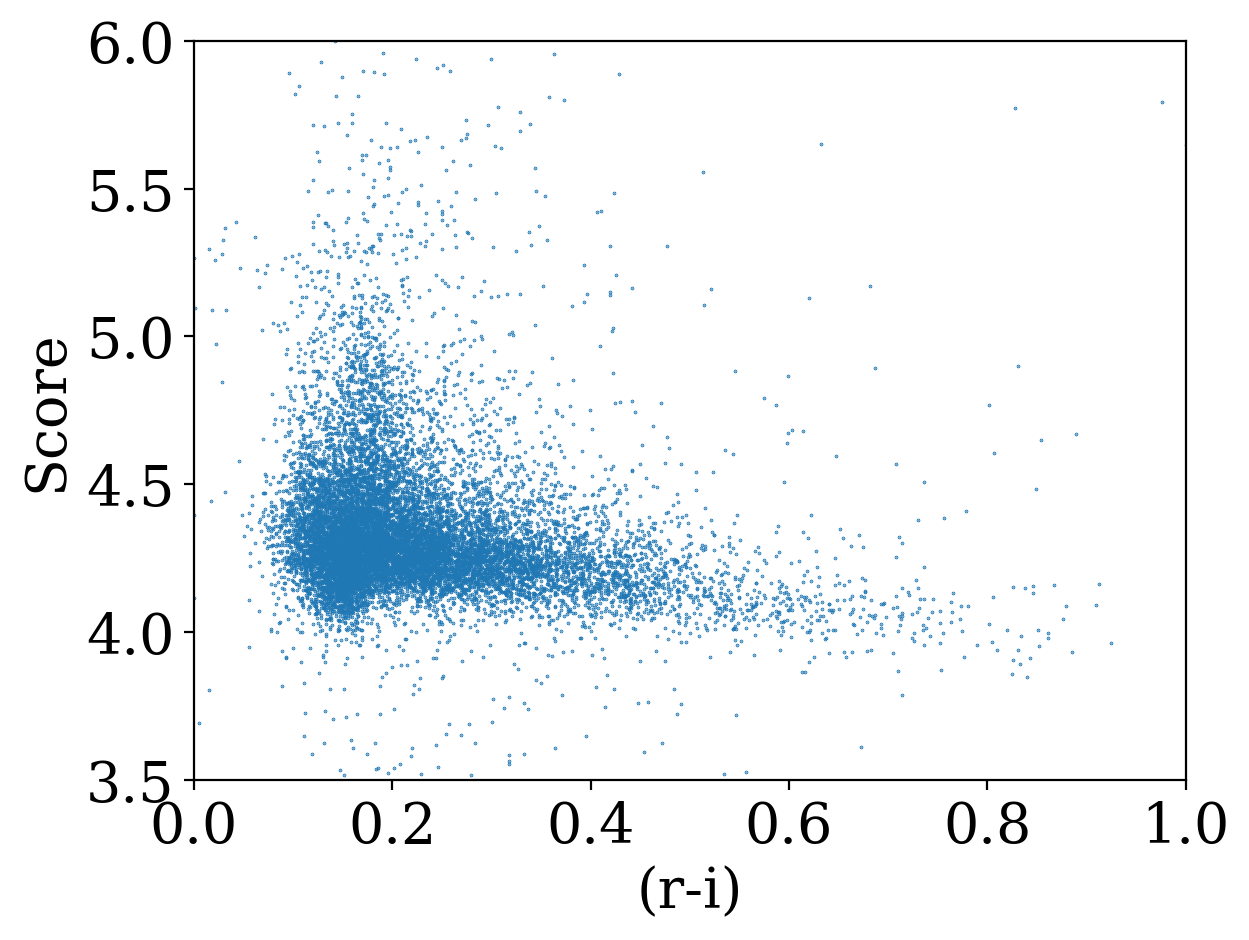

In [86]:
plt.scatter(fg['ps1_rMeanPSFMag_ztf_dr14'].values-fg['ps1_iMeanPSFMag_ztf_dr14'].values, 
            abs(fg['best_dip_score'].values), 
           s=0.1) 
           #c=fg['ps1_gMeanPSFMag_ztf_dr14'].values-fg['ps1_rMeanPSFMag_ztf_dr14'].values, 
           #vmin=-1, vmax=1)

plt.ylim(3.5, 6)
plt.xlim(0, 1)
plt.ylabel("Score")
plt.xlabel("(r-i)")

Text(0.5, 0, 'N$_{dips}$')

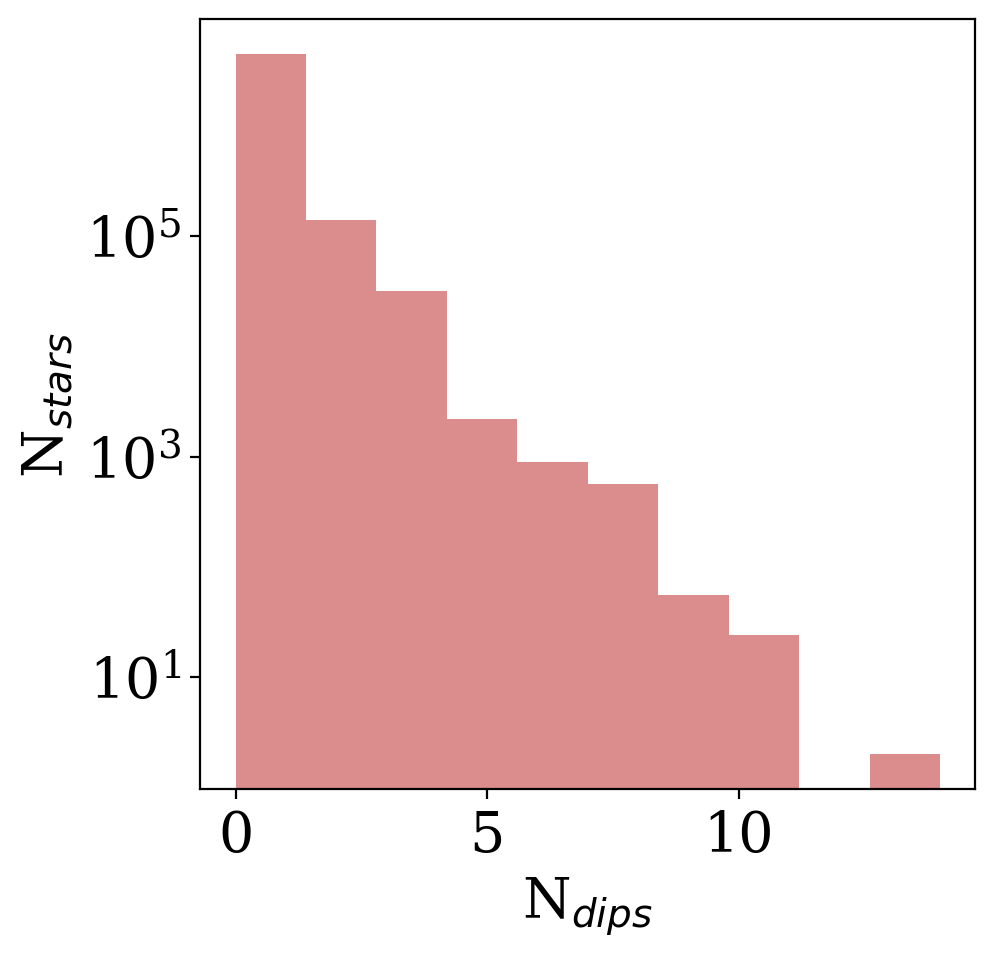

In [104]:
plt.figure(figsize=(5,5))
_ = plt.hist(fg['Ndips'], bins=10, 
            color='indianred', histtype='bar', 
            alpha=0.7)

plt.yscale('log')

plt.ylabel("N$_{stars}$")
plt.xlabel("N$_{dips}$")


Text(0.5, 0, 'MAD')

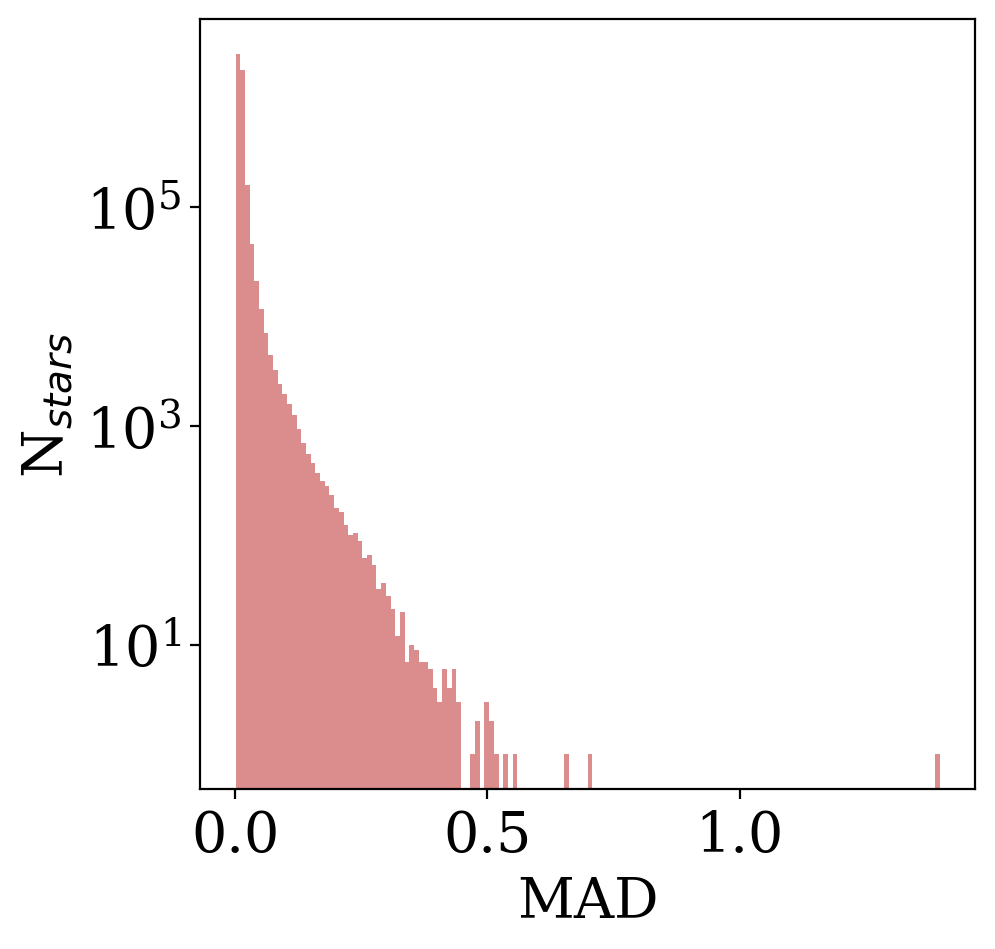

In [90]:
plt.figure(figsize=(5,5))
_ = plt.hist(fg['mad'], bins=150, 
            color='indianred', histtype='bar', 
            alpha=0.7)
plt.yscale('log')


plt.ylabel("N$_{stars}$")
plt.xlabel("MAD")

Text(0.5, 0, '$\\chi^{2}$$_{dof}$')

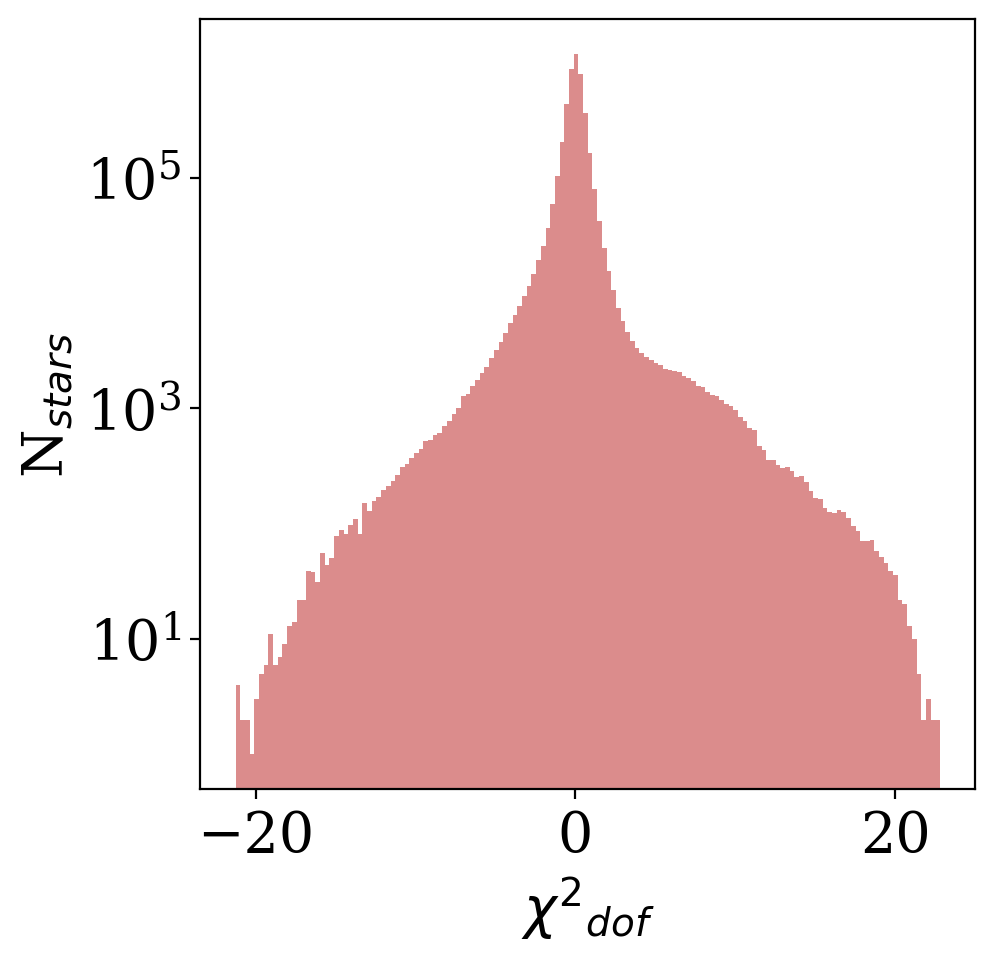

In [87]:
plt.figure(figsize=(5,5))
_ = plt.hist(fg['skew'], bins=150, 
            color='indianred', histtype='bar', 
            alpha=0.7)
plt.yscale('log')


plt.ylabel("N$_{stars}$")
plt.xlabel("Skew")

In [43]:
plt.figure(figsize=(5,5))
_ = plt.hist(fg['chi2dof'], bins=150, 
            color='indianred', histtype='bar', 
            alpha=0.7)
plt.yscale('log')


plt.ylabel("N$_{stars}$")
plt.xlabel("$\chi^{2}$$_{dof}$")

Text(0.5, 0, '$\\chi^{2}$$_{dof}$')

Text(0.5, 0, 'f$_{>2 \\sigma}$ [fraction]')

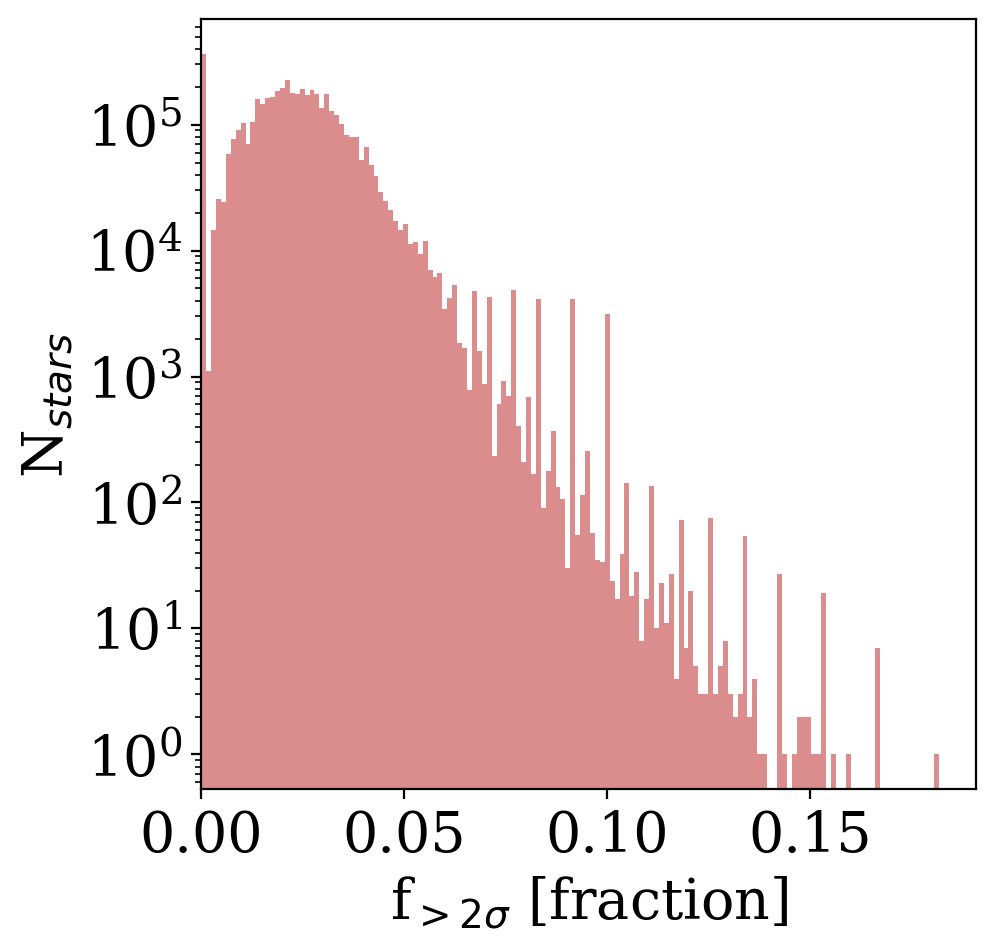

In [39]:
plt.figure(figsize=(5,5))
_ = plt.hist(fg['frac_above_2_sigma'], bins=150, 
            color='indianred', histtype='bar', 
            alpha=0.7)
plt.yscale('log')
plt.xlim(0)

plt.ylabel("N$_{stars}$")
plt.xlabel("f$_{>2 \sigma}$ [fraction]")

In [133]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Set up the subplots with shared y-axes
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)

# Define the Spectral colormap
cmap = cm.get_cmap('Spectral')

# Plot each histogram with a different color
variables = ['Ndips', 'mad', 'skew', 'chi2dof', 'frac_above_2_sigma', 'biweight_scale']
xlabels = ["N$_{dips}$", "MAD", "Skew", "$\chi^{2}$$_{dof}$", "f$_{>2 \sigma}$ [fraction]", "$\sigma_{bi}$"]

for i, (variable, xlabel) in enumerate(zip(variables, xlabels)):
    row, col = divmod(i, 3)
    ax = axes[row, col]

    # Filter out NaN and infinite values
    data = fg[variable].replace([np.inf, -np.inf], np.nan).dropna()

    # Plot histogram with a different color from the Spectral colormap
    color = cmap(i / len(variables))
    _ = ax.hist(data, bins=100, density=False, color=color, alpha=0.8, histtype='stepfilled', 
               edgecolor='k')

    # Set x-axis labels and make them more readable
    ax.set_xlabel(xlabel, labelpad=5)  # Adjust label padding

    # Add labels
    ax.set_ylabel("N$_{stars}$")
    ax.set_yscale('log')


    # Make borders more thick
    for spine in ax.spines.values():
        spine.set_linewidth(2)

# Adjust layout
plt.tight_layout()
plt.show()


/tmp/ipykernel_125782/3774923029.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral')


/tmp/ipykernel_125782/3784716710.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral')


0
1
2
3
4


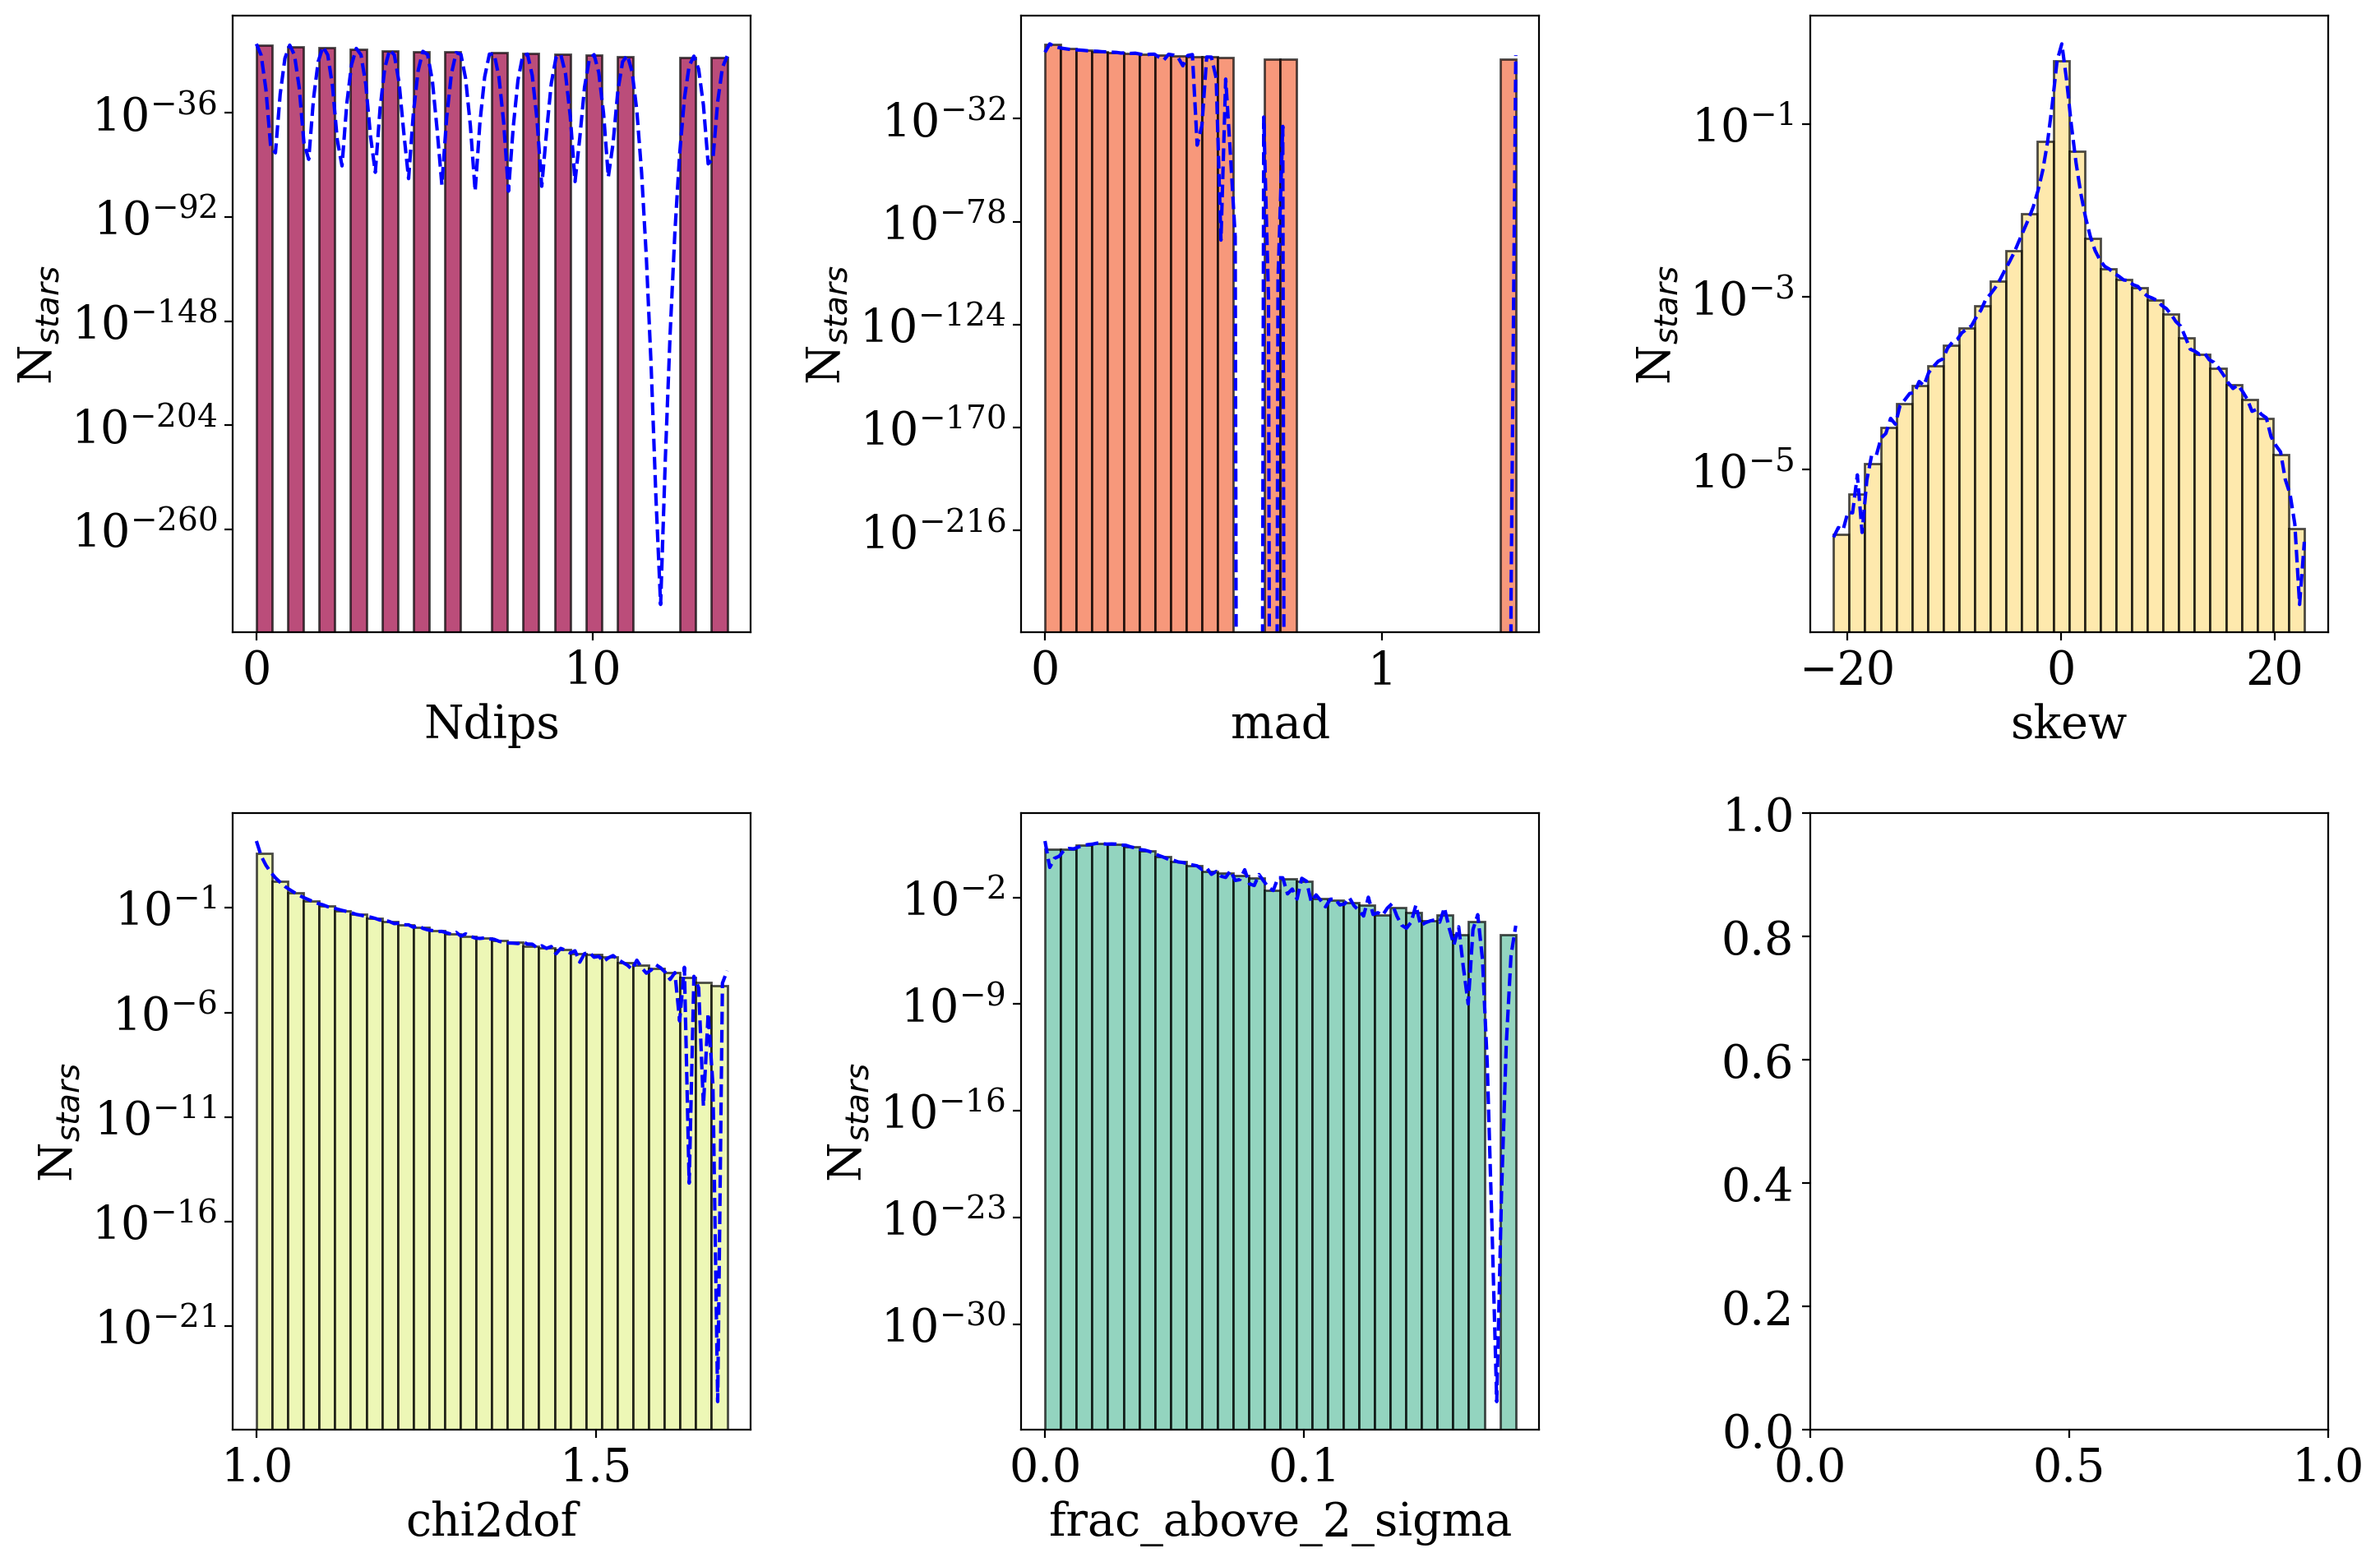

In [111]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib import cm

# Set up the subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

# Define the Spectral colormap
cmap = cm.get_cmap('Spectral')

# Plot each histogram and KDE fit
variables = ['Ndips', 'mad', 'skew', 'chi2dof', 'frac_above_2_sigma']

for i, variable in enumerate(variables):
    print (i)
    row, col = divmod(i, 3)
    ax = axes[row, col]

    # Filter out NaN and infinite values
    data = fg[variable].replace([np.inf, -np.inf], np.nan).dropna()

    # Plot histogram with a different color from the Spectral colormap
    color = cmap(i / len(variables))
    _, bins, _ = ax.hist(data, 
                         bins=30, 
                         density=True, 
                         color=color, 
                         alpha=0.7, edgecolor='black')

    # Calculate KDE fit
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 100)
    y_vals = kde(x_vals)

    # Plot KDE fit
    ax.plot(x_vals, y_vals, color='blue', linestyle='--')

    # Set y-axis to log scale
    ax.set_yscale('log')

    # Add labels
    ax.set_ylabel("N$_{stars}$")
    ax.set_xlabel(variable)

# Adjust layout
plt.tight_layout()
plt.show()


/tmp/ipykernel_125782/219515865.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral')


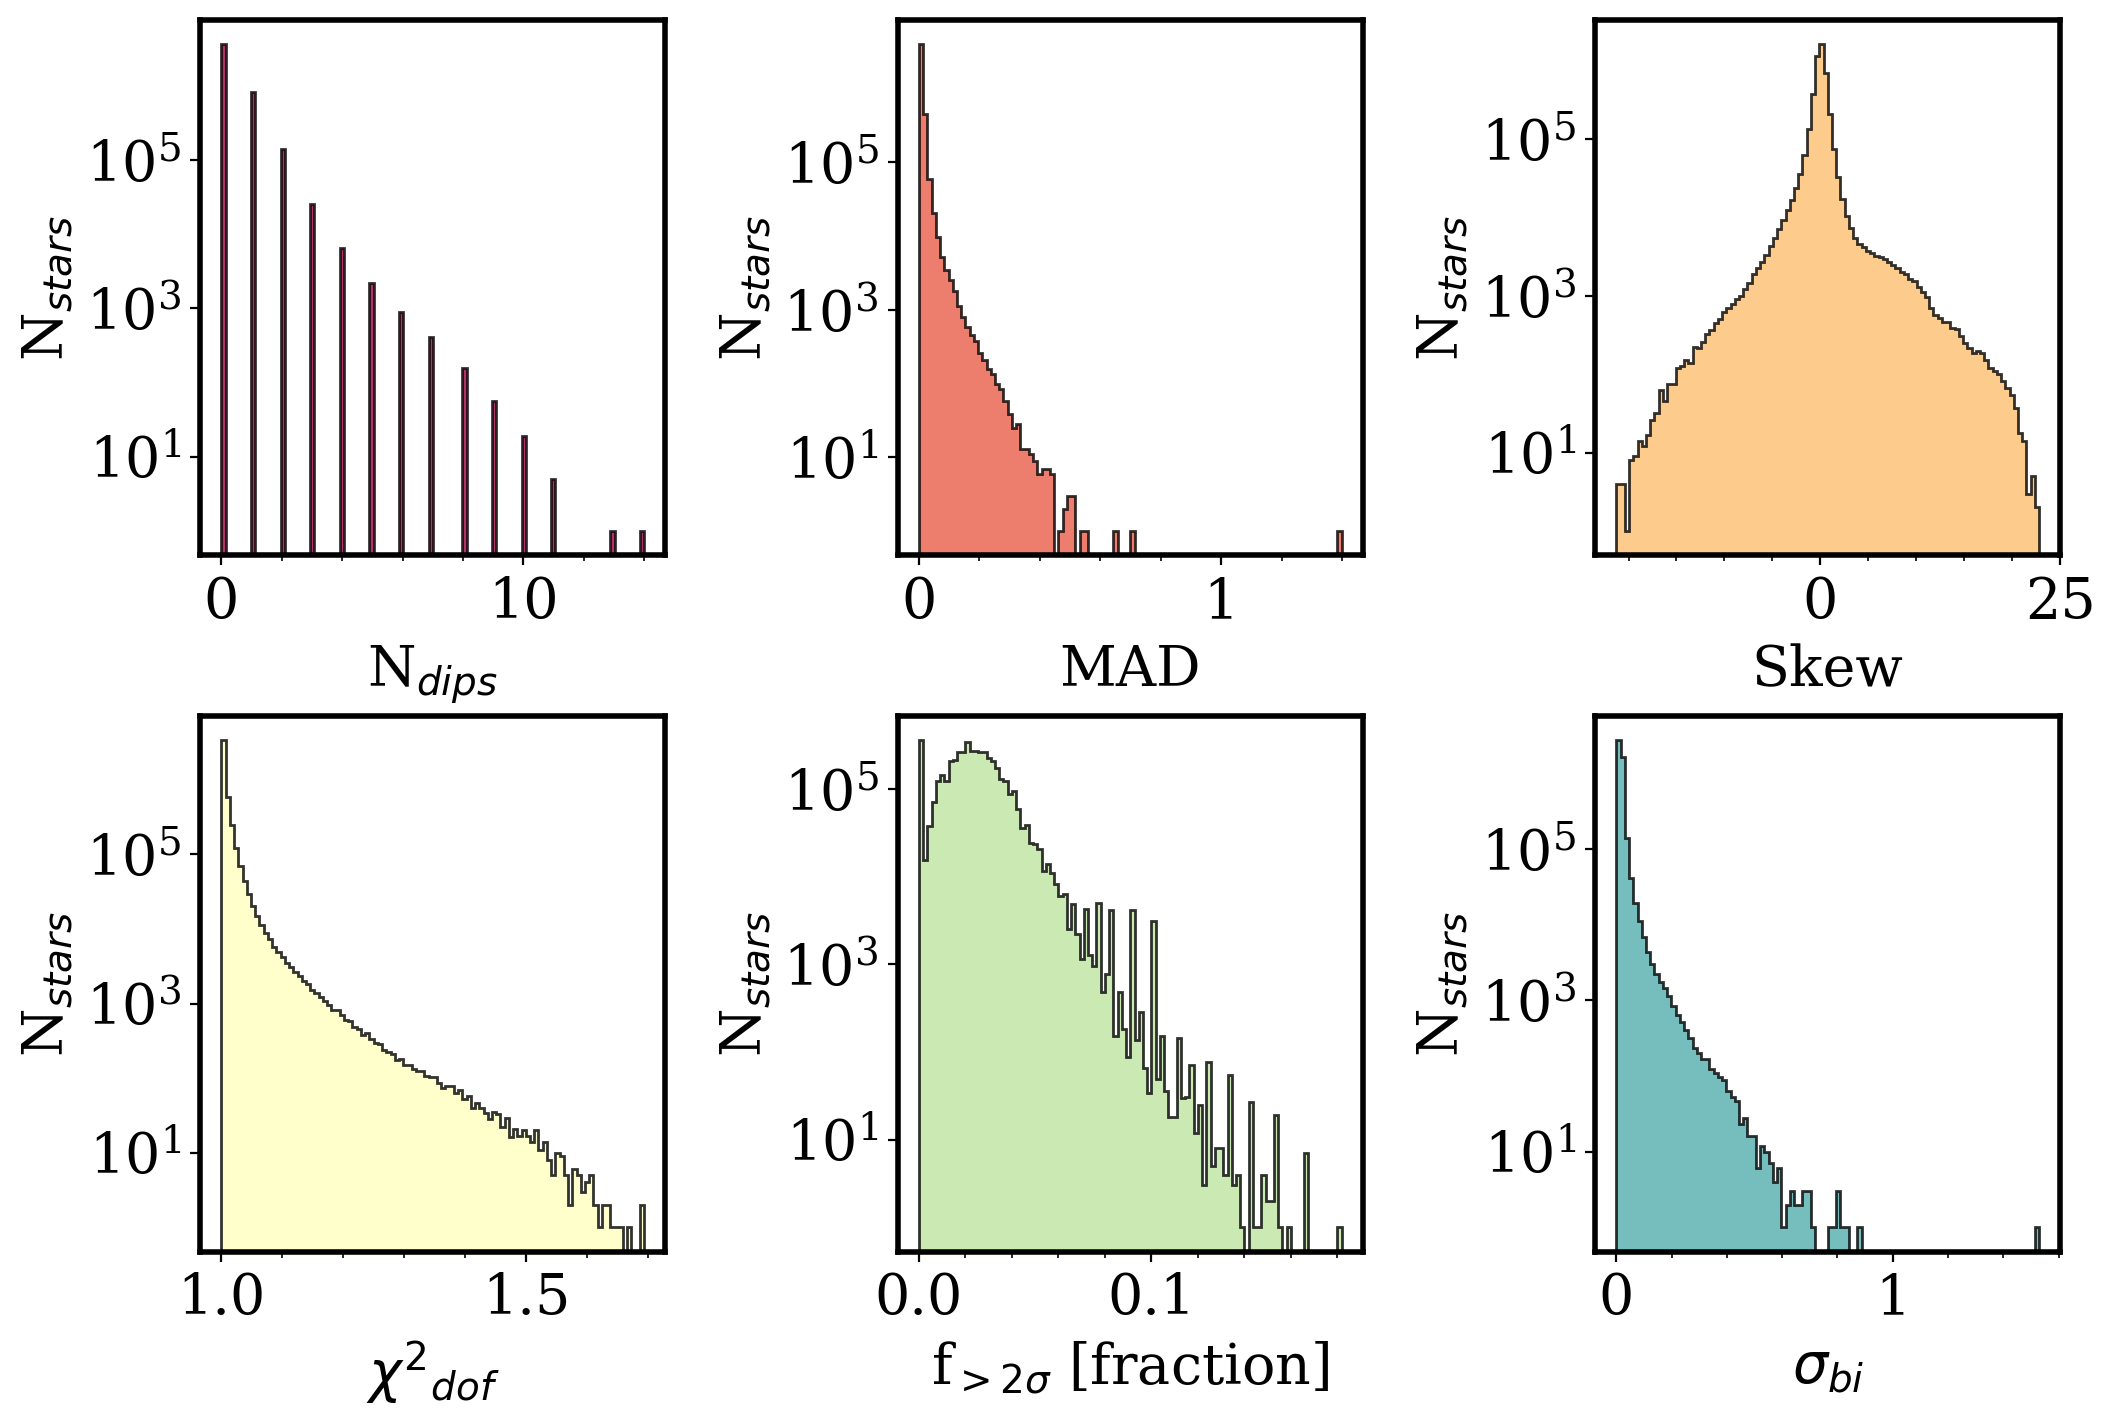

In [140]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Set up the subplots with shared y-axes
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.5)

# Define the Spectral colormap
cmap = cm.get_cmap('Spectral')

# Plot each histogram with a different color
variables = ['Ndips', 'mad', 'skew', 'chi2dof', 'frac_above_2_sigma', 'biweight_scale']
xlabels = ["N$_{dips}$", "MAD", "Skew", "$\chi^{2}$$_{dof}$", "f$_{>2 \sigma}$ [fraction]", "$\sigma_{bi}$"]

for i, (variable, xlabel) in enumerate(zip(variables, xlabels)):
    row, col = divmod(i, 3)
    ax = axes[row, col]

    # Filter out NaN and infinite values
    data = fg[variable].replace([np.inf, -np.inf], np.nan).dropna()

    # Plot histogram with a different color from the Spectral colormap
    color = cmap(i / len(variables))
    _ = ax.hist(data, bins=100, density=False, color=color, alpha=0.8, histtype='stepfilled',
                edgecolor='k')

    # Set x-axis labels and make them more readable
    ax.set_xlabel(xlabel, labelpad=5)  # Adjust label padding

    # Add labels
    ax.set_ylabel("N$_{stars}$")
    ax.set_yscale('log')

    # Enable minor ticks
    ax.minorticks_on()

    # Make borders more thick
    for spine in ax.spines.values():
        spine.set_linewidth(2)

# Adjust layout

plt.show()


In [ ]:
plt.scatter(1,1)
plt.minorticks_on

In [73]:
cut_1 = fg[(fg['Ndips']>0) & (fg["best_dip_power"]>3)]

In [74]:
cut_1 = cut_1.head(10_000)

In [75]:
# Assuming s is your DataFrame with columns 'ra' and 'dec'
s = pd.DataFrame({"ra": cut_1['ra_gaia'].values,
                  "dec": cut_1['dec_gaia'].values})

ss = Table.from_pandas(s)

In [ ]:
!pwd

In [77]:
ss.write('my_table_again.ipac',format='ipac', overwrite=True)

In [56]:
!ls

Aliasing Dippers in ZTF.ipynb
All Sky FGK Dwarf Search.ipynb
Full FG Dwarf Dipper Search Initial.ipynb
Light Curve Filtering and Fitting Validation.ipynb
MultiBand Dipper FG Search.ipynb
Selecting Main-Sequence Stars from StarHorse.ipynb
[Concept-1] Dip Detections FG Stars.ipynb
my_table_again
my_table_again.ipac
mytable_1.txt


In [381]:
# Stored on Feb 17th 
#%%time
#full_table.to_parquet("/epyc/ssd/users/atzanida/tmp/fg_full_feb16.parquet", engine='pyarrow')

CPU times: user 21 s, sys: 20.2 s, total: 41.2 s
Wall time: 20.9 s


In [389]:
plot_lc(8199126471550173184, 100)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


_hipscat_index
8199126471550173184    280.434887
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
8199126471550173184   -17.288974
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


_hipscat_index
9186493922698854400    275.515277
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
9186493922698854400    34.087044
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


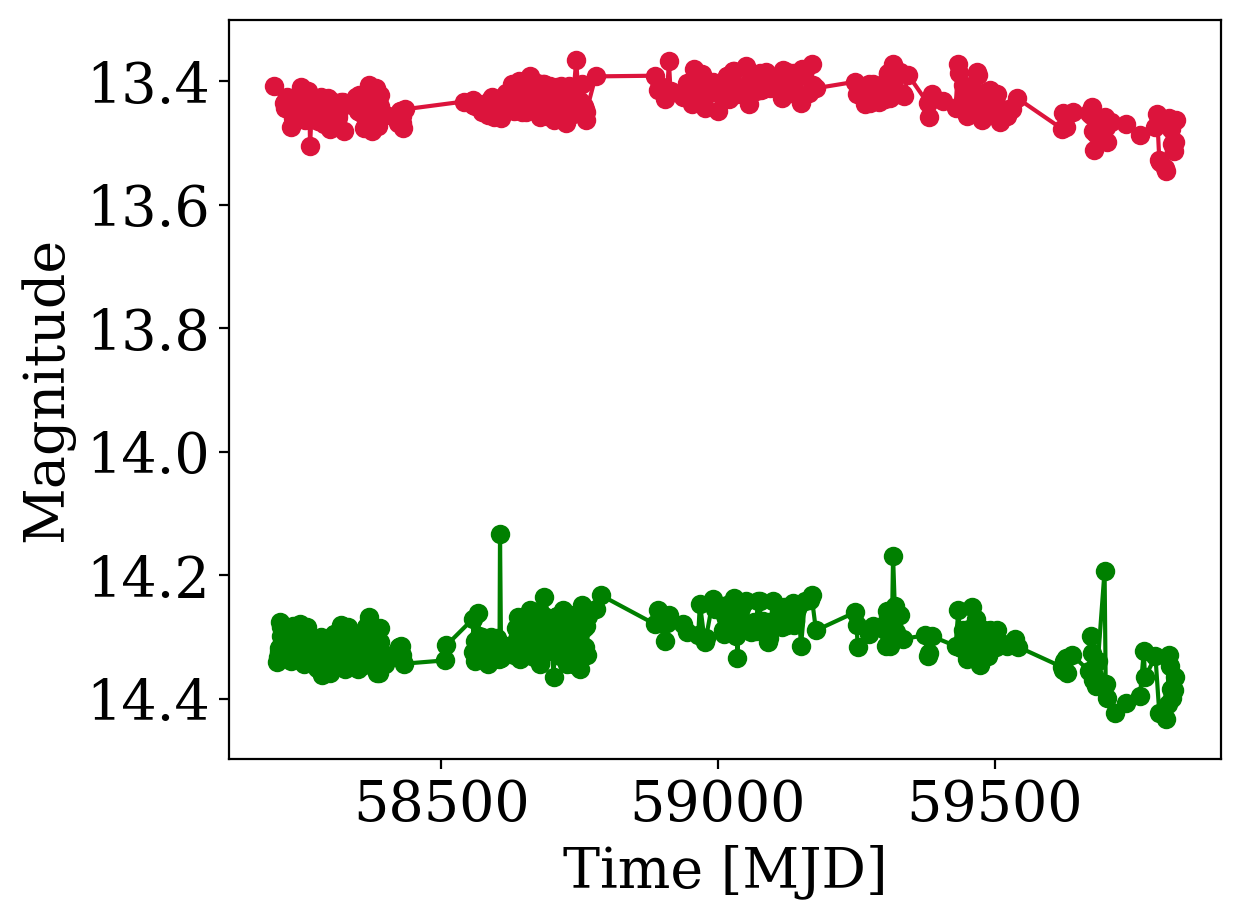

In [229]:
plot_lc(9186493922698854400, 100)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


_hipscat_index
3745754366611554304    313.505736
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
3745754366611554304    39.500802
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


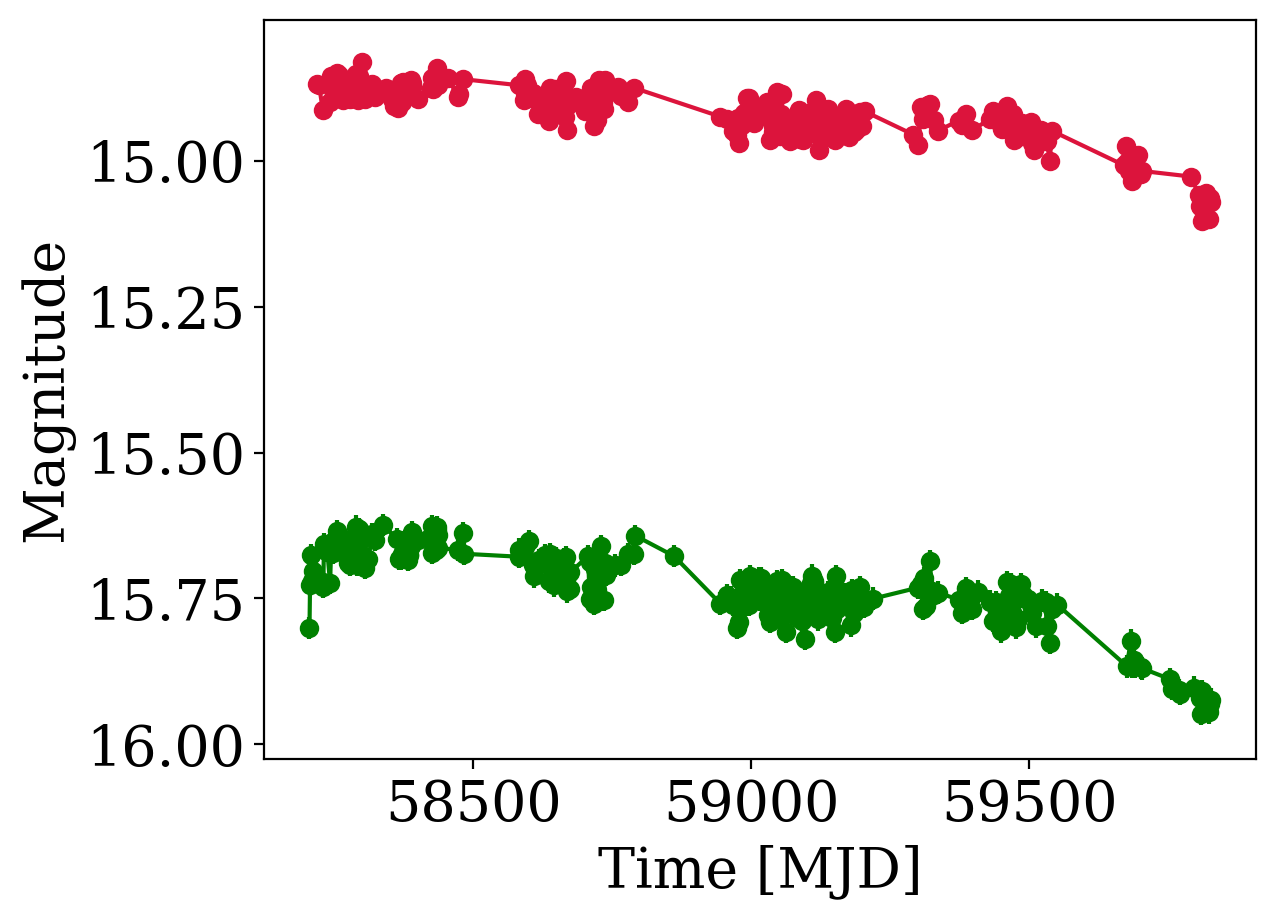

In [228]:
plot_lc(3745754366611554304, 100)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


_hipscat_index
8638660225169096704    288.438754
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
8638660225169096704    13.369443
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


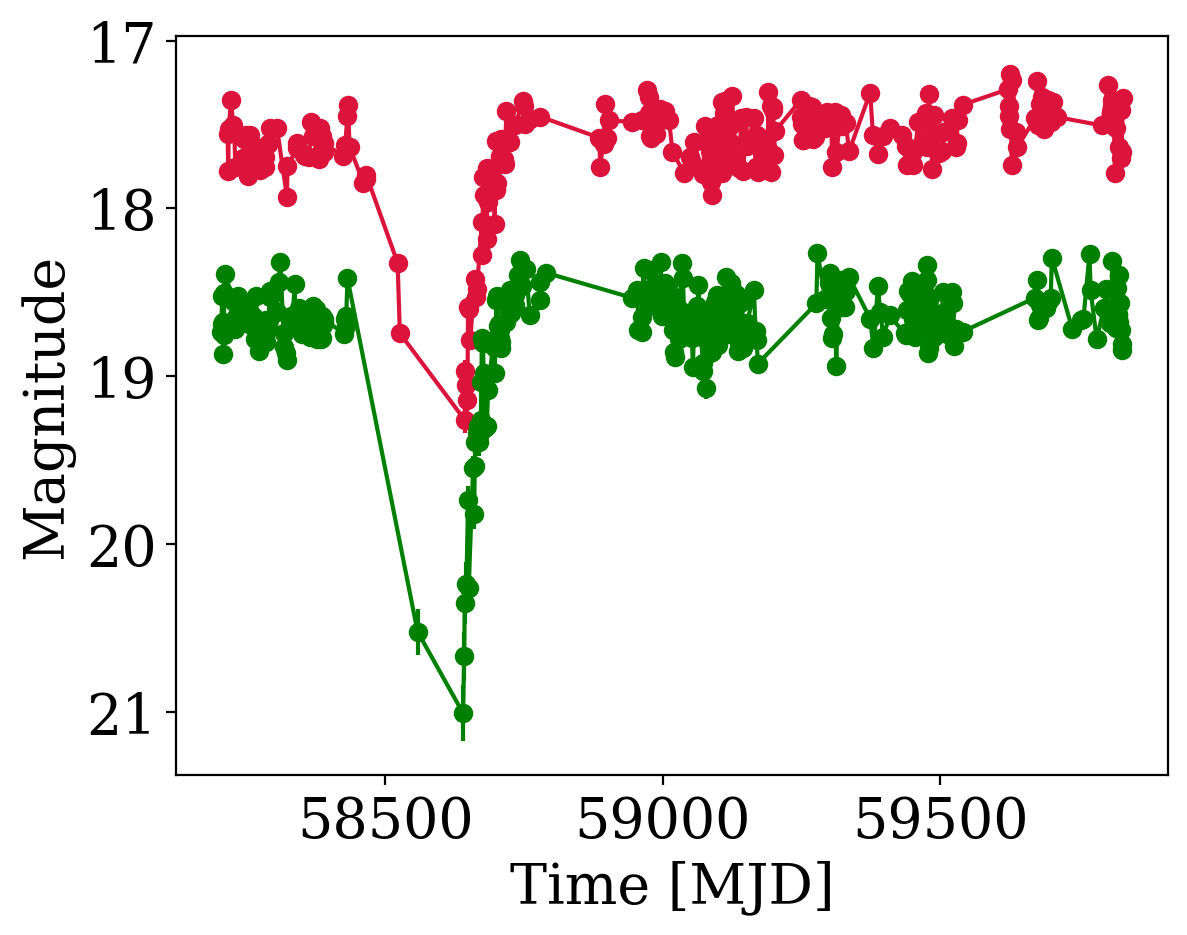

In [177]:
plot_lc(8638660225169096704, 100)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


_hipscat_index
3654136346231963648    298.936434
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
3654136346231963648    21.703686
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


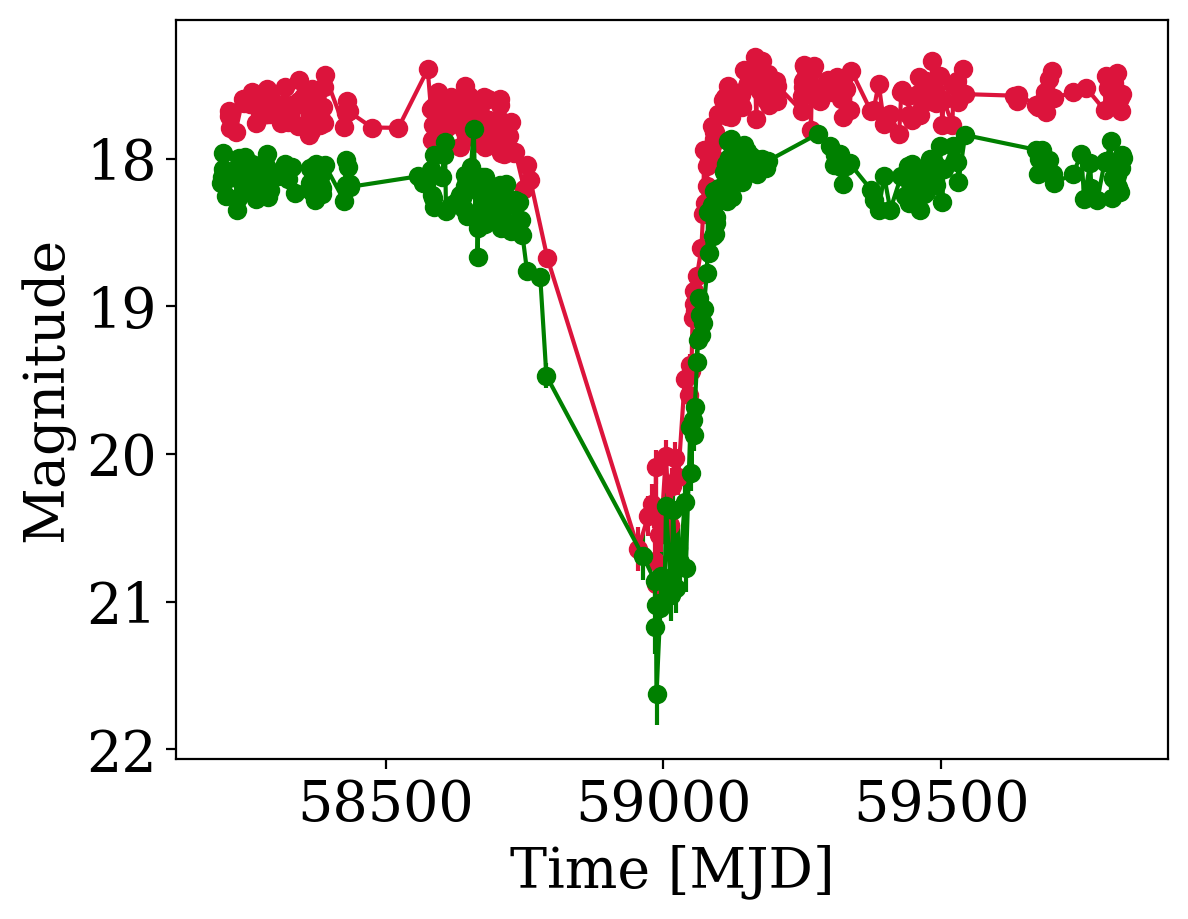

In [176]:
plot_lc(3654136346231963648, 100)

In [520]:
qsl = (full_table['invNeumann']>4) & (full_table['Nphot']>50)

In [ ]:
plt.scatter(full_table['teff_gspphot_gaia'], 
           full_table['logg_gspphot_gaia'], 
           s=0.001, color='k', alpha=0.2)

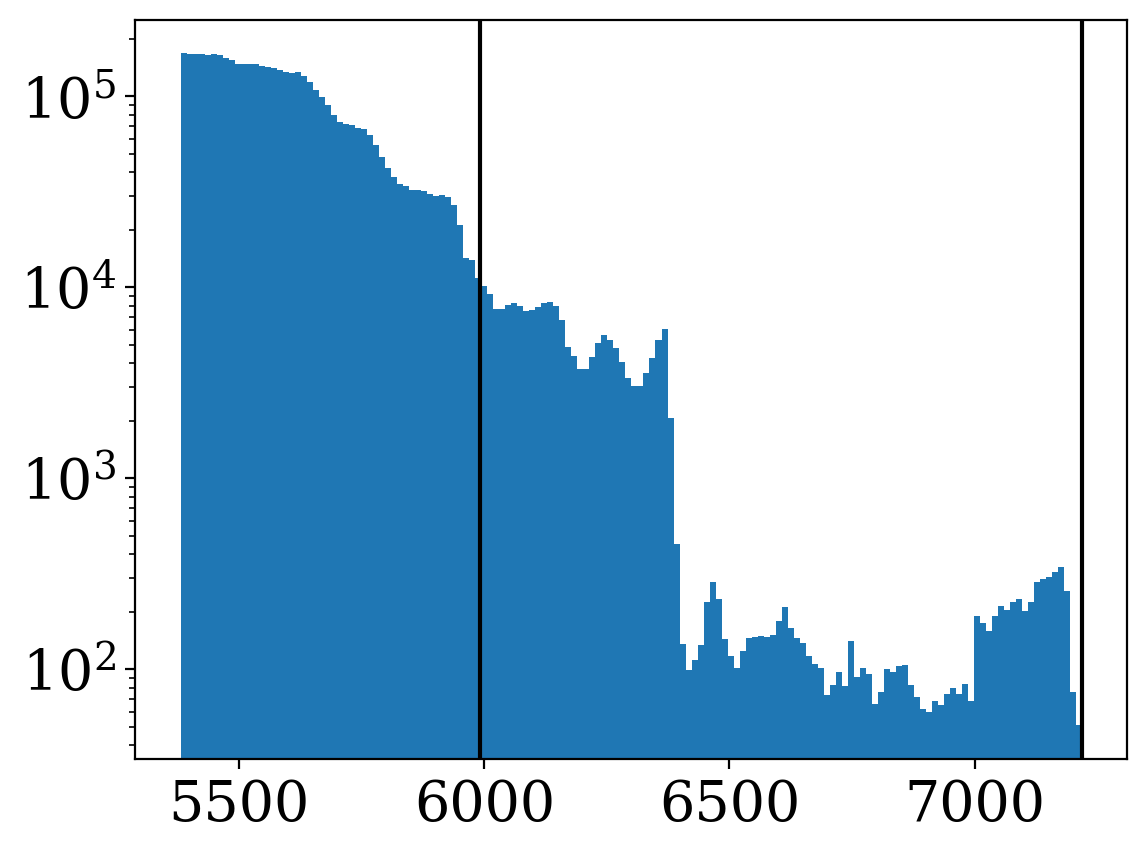

In [533]:

_ = plt.hist(full_table['teff_gspphot_gaia'], 
            bins=150)
plt.axvline(7220,color='k')
plt.axvline(5990, color='k')
plt.yscale('log')

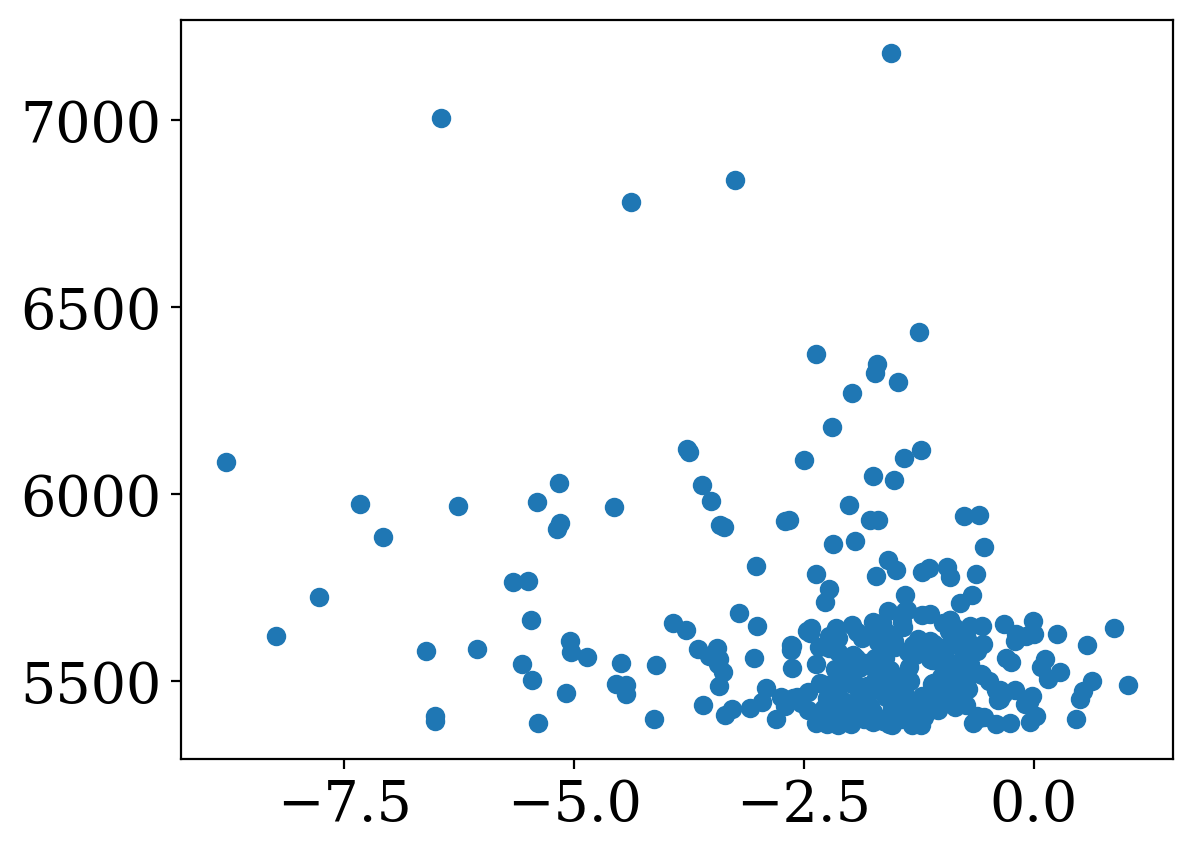

In [521]:
plt.scatter(full_table['ADF_const'][qsl], 
            full_table['teff_gspphot_gaia'][qsl])


In [372]:
full_table[(full_table['invNeumann']>10) & (full_table['Nphot']>100)]

ra_gaia   dec_gaia  parallax_gaia  \
_hipscat_index                                               
376482410046423040     77.610503  38.451216       0.742675   
875704368945430528     43.200927  48.402967       0.707727   
912604526391853056     30.891738  54.138836       2.219919   
1758465217743814656   117.203602  30.619442       1.891911   
1973543997439737856   109.404180  53.736505       3.217838   
3614867075694067712   298.718851  14.486473       0.812731   
3643135419052195840   298.244356  18.329648       0.335807   
3839855433447636992   353.397544  38.995166       1.960577   
3854352942987476992   359.360428  46.568823       0.269425   
3949235599092744192   326.175991  46.252813       0.801609   
3956573435437514752   322.616061  47.256067       1.333464   
3972329942397485056   335.959217  45.647761       1.441777   
4052892041040887808   291.810076  28.779683       1.015038   
6185316543975391232   126.616706   4.734390       0.643815   
6647638525443309568    96.067622   5.611124       1.461345   
8351435468583206912   268.219934  -5.007170       1.787534   
8387204843176984576   298.023710  -9.590792       1.731480   
8477635159774986240   295.858232   0.024518       7.125123   
8586505850565165056   289.280336   4.779257       1.055265   
8827683382746939392   229.855491  -3.705413       2.334395   
9048417780415594496   278.092231  18.223677       0.403267   
11488797531337392128  140.735257  -9.016836       1.021299   
12598558307767025664  218.105035 -14.271878       0.838744   

                      parallax_over_error_gaia  bp_rp_gaia  \
_hipscat_index                                               
376482410046423040                   15.267331    1.214294   
875704368945430528                    7.898079    1.045765   
912604526391853056                   40.445385    2.061901   
1758465217743814656                  56.661762    1.462400   
1973543997439737856                 165.796050    1.473635   
3614867075694067712                  16.815780    1.437437   
3643135419052195840                   5.249795    1.370608   
3839855433447636992                  49.888203    1.755708   
3854352942987476992                   5.391088    0.827328   
3949235599092744192                  25.117517    1.099375   
3956573435437514752                  51.620335    1.408124   
3972329942397485056                  70.508390    1.146826   
4052892041040887808                  32.420860    1.118641   
6185316543975391232                  10.215450    0.845312   
6647638525443309568                  59.908900    0.295625   
8351435468583206912                  47.460330    1.816873   
8387204843176984576                  25.223408    1.996995   
8477635159774986240                 286.317930    0.978822   
8586505850565165056                  22.104849    1.533112   
8827683382746939392                  89.395905    1.379408   
9048417780415594496                   8.464892    1.162750   
11488797531337392128                 29.159943    1.141900   
12598558307767025664                 19.618835    1.051384   

                         solution_id_gaia       source_id_gaia  pmra_gaia  \
_hipscat_index                                                              
376482410046423040    1636148068921376768   188241205337803520   0.386979   
875704368945430528    1636148068921376768   437852163277730688   0.584179   
912604526391853056    1636148068921376768   456302243269796480   2.299194   
1758465217743814656   1636148068921376768   879232586346559488 -18.597252   
1973543997439737856   1636148068921376768   986771966071677056 -31.508382   
3614867075694067712   1636148068921376768  1807433533673129728   0.360208   
3643135419052195840   1636148068921376768  1821567686942955264  -3.367250   
3839855433447636992   1636148068921376768  1919927695021001472  31.140599   
3854352942987476992   1636148068921376768  1927176465945060736  -2.307761   
3949235599092744192   1636148068921376768  1974617777046679296  -2.111668   

In [469]:
%%time
lc_1 = lc_split(8351435468583206912)
lc_2 = lc_split(6185316543975391232)
lc_3 = lc_split(11488797531337392128)
lc_4 = lc_split(376482410046423040)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scatte

CPU times: user 1min 15s, sys: 12.1 s, total: 1min 27s
Wall time: 1min 28s


In [487]:
save_plot = False
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, 
                      figsize=(11, 7))
plt.subplots_adjust(wspace=0.01)

ax[0,0].errorbar(lc_1[0], np.min(lc_1[1])/lc_1[1], lc_1[2]/np.min(lc_1[1]), fmt='.', 
                color='mediumvioletred')
ax[0,0].errorbar(lc_1[3], np.min(lc_1[4])/lc_1[4], lc_1[5]/np.min(lc_1[4]), fmt='.', 
                color='seagreen')

ax[1,0].errorbar(lc_2[0], np.min(lc_2[1])/lc_2[1], lc_2[2]/np.min(lc_2[1]), fmt='.', 
                color='mediumvioletred')
ax[1,0].errorbar(lc_2[3], np.min(lc_2[4])/lc_2[4], lc_2[5]/np.min(lc_2[4]), fmt='.', 
                color='seagreen')
ax[1,0].errorbar(lc_2[6], np.min(lc_2[7])/lc_2[7], lc_2[8]/np.min(lc_2[7]), fmt='.', 
                color='k')


ax[0,1].errorbar(lc_3[0], np.min(lc_3[1])/lc_3[1], lc_3[2]/np.min(lc_3[1]), fmt='.',
                color='mediumvioletred')
ax[0,1].errorbar(lc_3[3], np.min(lc_3[4])/lc_3[4], lc_3[5]/np.min(lc_3[4]), fmt='.', 
                color='seagreen')
ax[0,1].errorbar(lc_3[6], np.min(lc_3[7])/lc_3[7], lc_3[8]/np.min(lc_3[7]), fmt='.', 
                color='k')


ax[1,1].errorbar(lc_4[0], np.min(lc_4[1])/lc_4[1], lc_4[2]/np.min(lc_4[1]), fmt='.',
                color='mediumvioletred', 
                label='ZTF-r')
ax[1,1].errorbar(lc_4[3], np.min(lc_4[4])/lc_4[4], lc_4[5]/np.min(lc_4[4]), fmt='.', 
                color='seagreen', 
                label='ZTF-g')
ax[1,1].errorbar(lc_4[6], np.min(lc_4[7])/lc_4[7], lc_4[8]/np.min(lc_4[7]), fmt='.', 
                color='k', 
                label='ZTF-i')


for i in range(2):
    for j in range(2):
        ax[i,j].axhline(1, color='k', ls='--', alpha=0.7)

        
ax[1,1].set_xlabel("Time [MJD]")
ax[1,0].set_xlabel("Time [MJD]")

ax[0,0].set_ylabel("Normalized Mag.")
ax[1,0].set_ylabel("Normalized Mag.")

plt.minorticks_on()
plt.legend(bbox_to_anchor=(1,2.5), ncols=3)

if save_plot:
    plt.savefig("/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/paperfigs/slow_demo_1.pdf",
               bbox_inches='tight', format='pdf', dpi=500)

<ErrorbarContainer object of 3 artists>

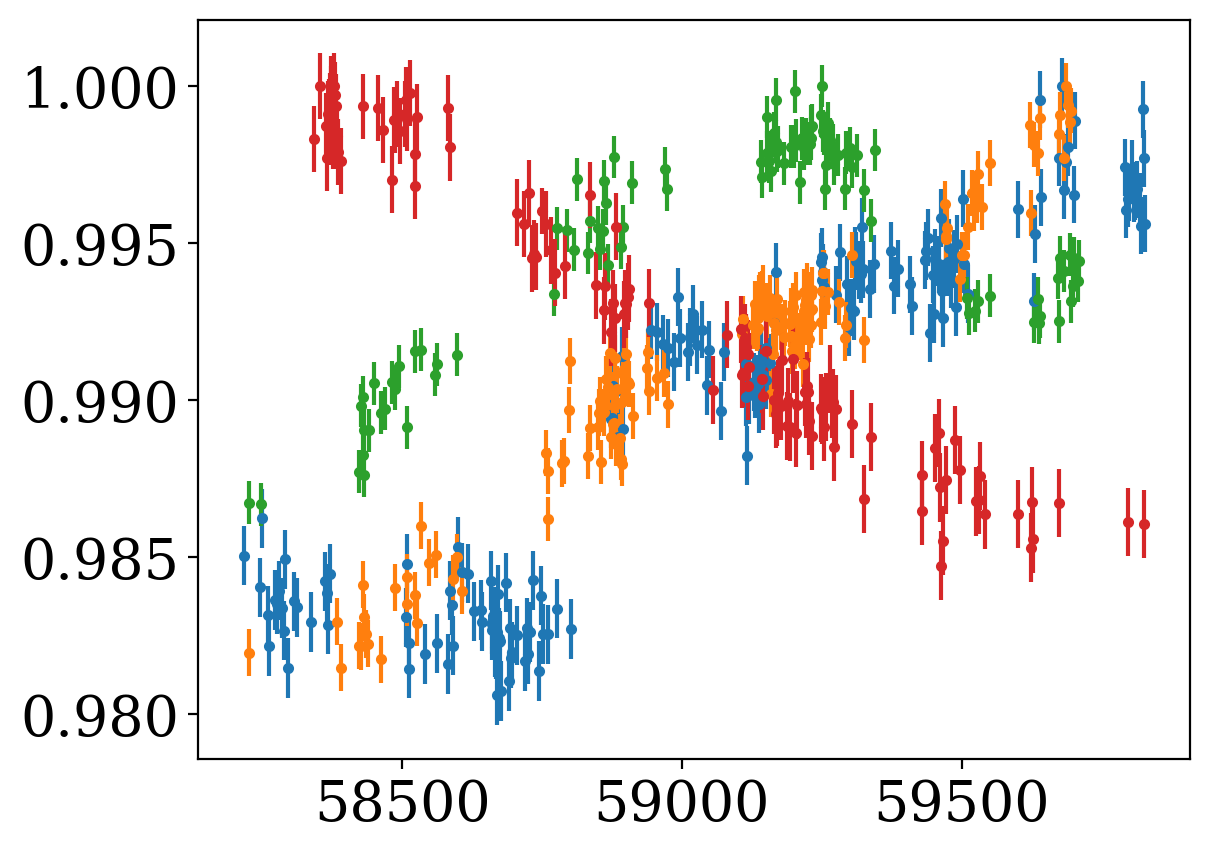

In [431]:
plt.errorbar(lc_1[0], np.min(lc_1[1])/lc_1[1], lc_1[2]/np.min(lc_1[1]), fmt='.')
plt.errorbar(lc_2[0], np.min(lc_2[1])/lc_2[1], lc_2[2]/np.min(lc_2[1]), fmt='.')
plt.errorbar(lc_3[0], np.min(lc_3[1])/lc_3[1], lc_3[2]/np.min(lc_3[1]), fmt='.')
plt.errorbar(lc_4[0], np.min(lc_4[1])/lc_4[1], lc_4[2]/np.min(lc_4[1]), fmt='.')
plt.minorticks_on()

In [468]:
def lc_split(_id):
        lc = ens.source.loc[_id]
        lc = lc.compute()

        time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                           lc['mag_ztf_source'].values, 
                           lc['magerr_ztf_source'].values, 
                           lc['catflags_ztf_source'].values,
                           lc['band_ztf_source'].values, band_of_study='r', flag_good=0)

        timeg, magg, magerrg = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                           lc['mag_ztf_source'].values, 
                           lc['magerr_ztf_source'].values, 
                           lc['catflags_ztf_source'].values,
                           lc['band_ztf_source'].values, band_of_study='g', flag_good=0)
        
        timei, magi, magerri = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='i', flag_good=0)
        
        return time, mag, magerr, timeg, magg, magerrg, timei, magi, magerri

In [111]:
def plot_lc(_id, loc):
    lc = ens.source.loc[_id]
    lc = lc.compute()
    th = lc.head(1)
    print (th['ra_gaia_andy_fg_dwarfs'], th['dec_gaia_andy_fg_dwarfs'])

    time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                       lc['mag_ztf_source'].values, 
                       lc['magerr_ztf_source'].values, 
                       lc['catflags_ztf_source'].values,
                       lc['band_ztf_source'].values, band_of_study='r', flag_good=0)

    timeg, magg, magerrg = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                       lc['mag_ztf_source'].values, 
                       lc['magerr_ztf_source'].values, 
                       lc['catflags_ztf_source'].values,
                       lc['band_ztf_source'].values, band_of_study='g', flag_good=0)

    plt.figure()
    plt.errorbar(time, mag, magerr, fmt='-o', color='Crimson')
    plt.errorbar(timeg, magg, magerrg, fmt='-o', color='green')

    plt.xlabel("Time [MJD]")
    plt.ylabel("Magnitude")

    plt.ylim(plt.ylim()[::-1])

In [186]:
q = (demo_table['Ndips']>0) & (demo_table['best_dip_ndet']>3)

In [188]:
len(demo_table[q]['best_dip_time_loc'])

25

In [189]:
def plot_lc(_id, loc):
    lc = ens.source.loc[_id]
    lc = lc.compute()
    th = lc.head(1)
    print (th['ra_gaia_andy_fg_dwarfs'], th['dec_gaia_andy_fg_dwarfs'])

    time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                       lc['mag_ztf_source'].values, 
                       lc['magerr_ztf_source'].values, 
                       lc['catflags_ztf_source'].values,
                       lc['band_ztf_source'].values, band_of_study='r', flag_good=0)

    timeg, magg, magerrg = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                       lc['mag_ztf_source'].values, 
                       lc['magerr_ztf_source'].values, 
                       lc['catflags_ztf_source'].values,
                       lc['band_ztf_source'].values, band_of_study='g', flag_good=0)

    plt.figure()
    plt.errorbar(time, mag, magerr, fmt='-o', color='Crimson')
    plt.errorbar(timeg, magg, magerrg, fmt='-o', color='green')

    plt.xlabel("Time [MJD]")
    plt.ylabel("Magnitude")

    plt.axvline(loc)

    plt.ylim(plt.ylim()[::-1])

In [182]:
tc = 0
for i, j in tqdm(zip(demo_table[q]['best_dip_time_loc'], demo_table[q].index.values)):
    print ("Count index:", tc)
    print (j, i)
    tc+=1

17it [00:00, 12568.86it/s]

Count index: 0
214833630155898880 58370.41837
Count index: 1
349501193262727168 59816.47397
Count index: 2
352191967087558656 59223.24518
Count index: 3
366012772284104704 58487.26439
Count index: 4
377174417102340096 58365.50593
Count index: 5
378629381460852736 59689.17172
Count index: 6
389296206100037632 58370.49113
Count index: 7
391062914590572544 59219.26408
Count index: 8
393852297223864320 58875.21997
Count index: 9
393869823529975808 58875.21999
Count index: 10
393891728140009472 58882.14278
Count index: 11
393999705748537344 58750.48503
Count index: 12
394003811724689408 58735.5085
Count index: 13
394162237763223552 58376.51078
Count index: 14
466548498855100416 58837.25449
Count index: 15
499393348491018240 58508.22031
Count index: 16
513263658973790208 58373.49371


0it [00:00, ?it/s]/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
1it [00:12, 12.06s/it]

_hipscat_index
214833630155898880    32.300625
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
214833630155898880    27.839565
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2it [00:27, 14.06s/it]

_hipscat_index
349501193262727168    69.142275
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
349501193262727168    35.792187
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
3it [00:43, 14.78s/it]

_hipscat_index
352191967087558656    64.658024
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
352191967087558656    34.828519
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
4it [00:54, 13.54s/it]

_hipscat_index
366012772284104704    83.511686
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
366012772284104704    34.959714
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
5it [01:10, 14.29s/it]

_hipscat_index
375310573446889472    81.334989
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
375310573446889472    38.813459
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
6it [01:25, 14.40s/it]

_hipscat_index
377174417102340096    77.287698
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
377174417102340096    40.099766
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
7it [01:37, 13.82s/it]

_hipscat_index
378624580723408896    85.035515
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
378624580723408896    36.764737
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
8it [01:54, 14.76s/it]

_hipscat_index
378629381460852736    84.86072
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
378629381460852736    36.795529
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
9it [02:06, 13.88s/it]

_hipscat_index
389296206100037632    83.180749
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
389296206100037632    42.134971
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
10it [02:21, 14.38s/it]

_hipscat_index
391062914590572544    84.116859
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
391062914590572544    43.405593
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
11it [02:37, 14.83s/it]

_hipscat_index
393852297223864320    89.083765
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
393852297223864320    45.684106
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
12it [02:49, 13.92s/it]

_hipscat_index
393869823529975808    89.442633
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
393869823529975808    45.669346
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
13it [03:05, 14.48s/it]

_hipscat_index
393891728140009472    89.313155
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
393891728140009472    45.688713
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
14it [03:19, 14.51s/it]

_hipscat_index
393999705748537344    89.446583
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
393999705748537344    45.930415
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
15it [03:31, 13.69s/it]

_hipscat_index
394003811724689408    89.291086
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
394003811724689408    45.924093
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
16it [03:47, 14.41s/it]

_hipscat_index
394162237763223552    85.2961
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
394162237763223552    44.166758
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
17it [04:02, 14.46s/it]

_hipscat_index
394182263685775360    84.847747
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
394182263685775360    44.206548
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
18it [04:15, 14.10s/it]

_hipscat_index
429995186139955200    88.565683
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
429995186139955200    52.034904
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
19it [04:31, 14.49s/it]

_hipscat_index
433929782489513984    57.844229
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
433929782489513984    32.686114
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
20it [04:43, 13.78s/it]

_hipscat_index
466548498855100416    61.798953
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
466548498855100416    44.742578
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/tmp/ipykernel_85231/881428140.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
21it [04:57, 13.84s/it]

_hipscat_index
466813763140452352    61.239858
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
466813763140452352    45.140886
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
22it [05:11, 14.09s/it]

_hipscat_index
483051564215304192    52.235845
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
483051564215304192    43.780079
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
23it [05:23, 13.30s/it]

_hipscat_index
499393348491018240    54.091858
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
499393348491018240    49.459464
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
24it [05:37, 13.47s/it]

_hipscat_index
508117579458412544    70.38897
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
508117579458412544    46.271986
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
25it [05:50, 14.04s/it]

_hipscat_index
513263658973790208    75.968878
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
513263658973790208    50.669566
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


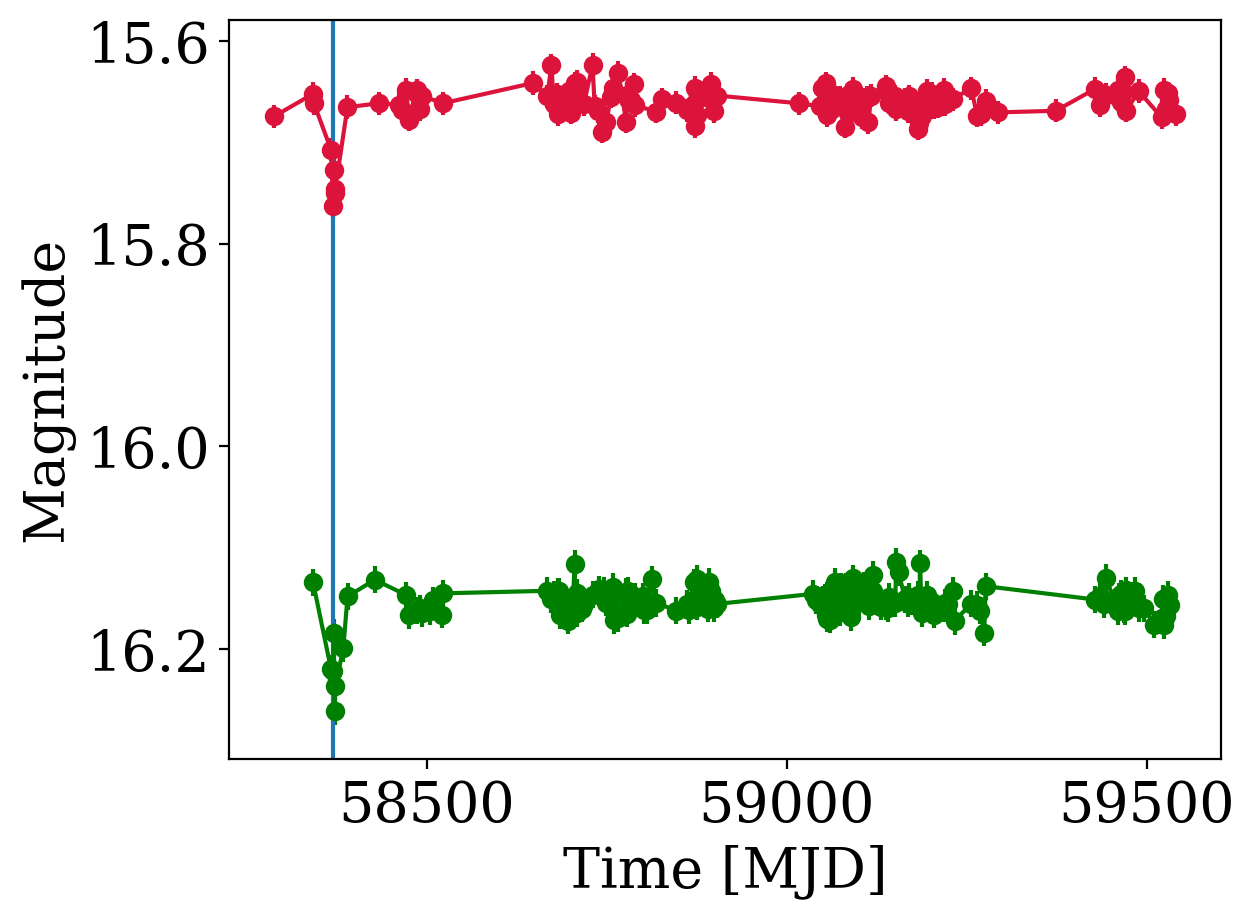

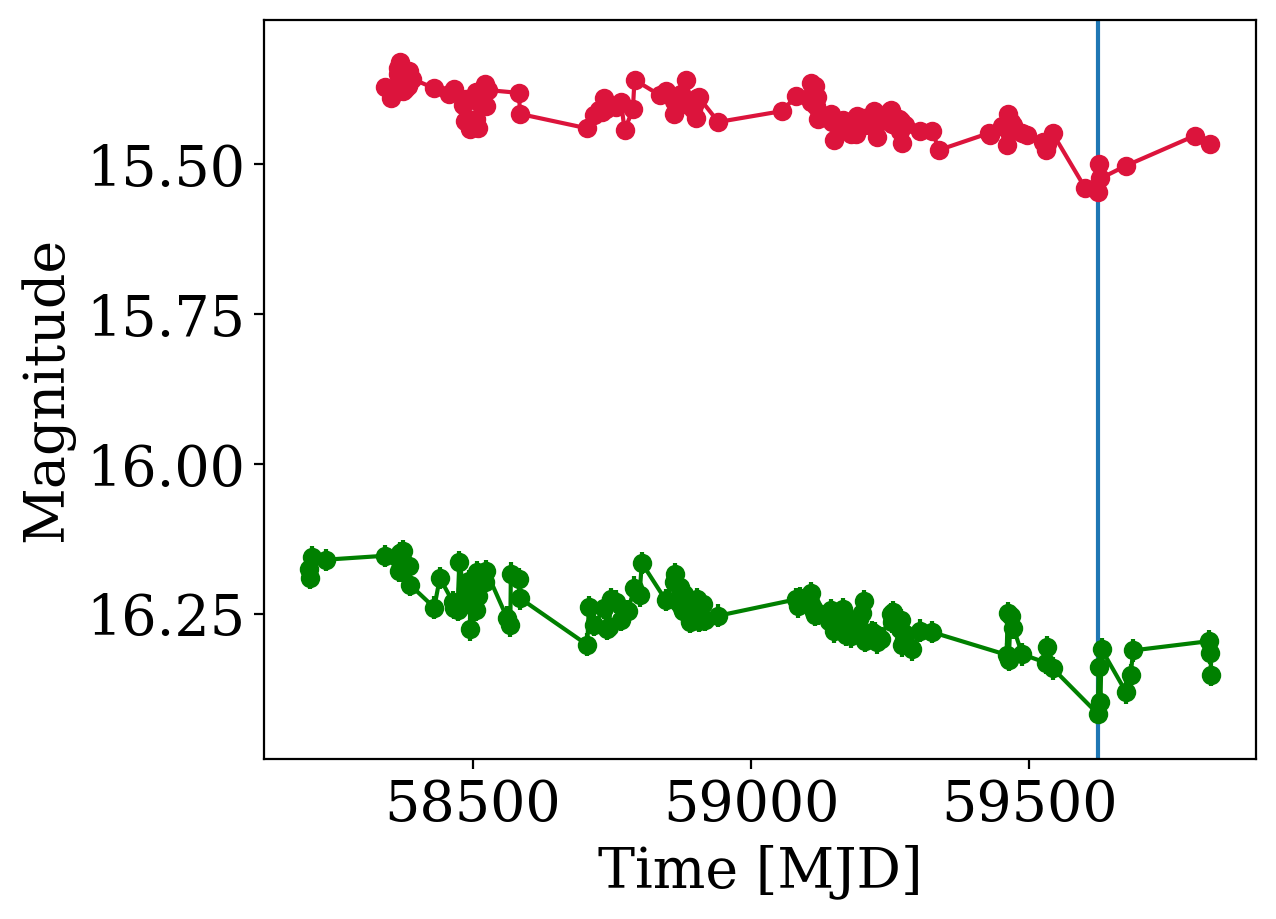

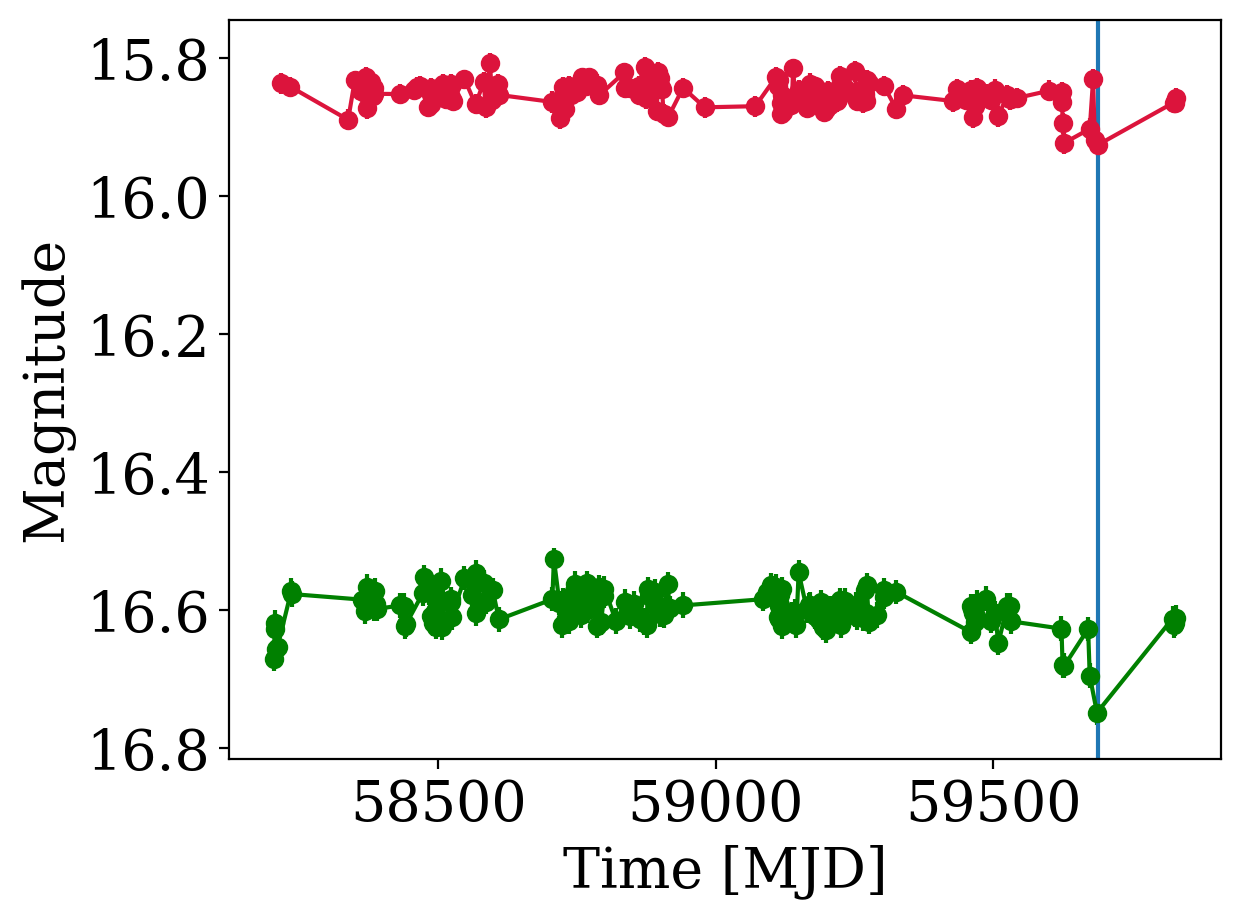

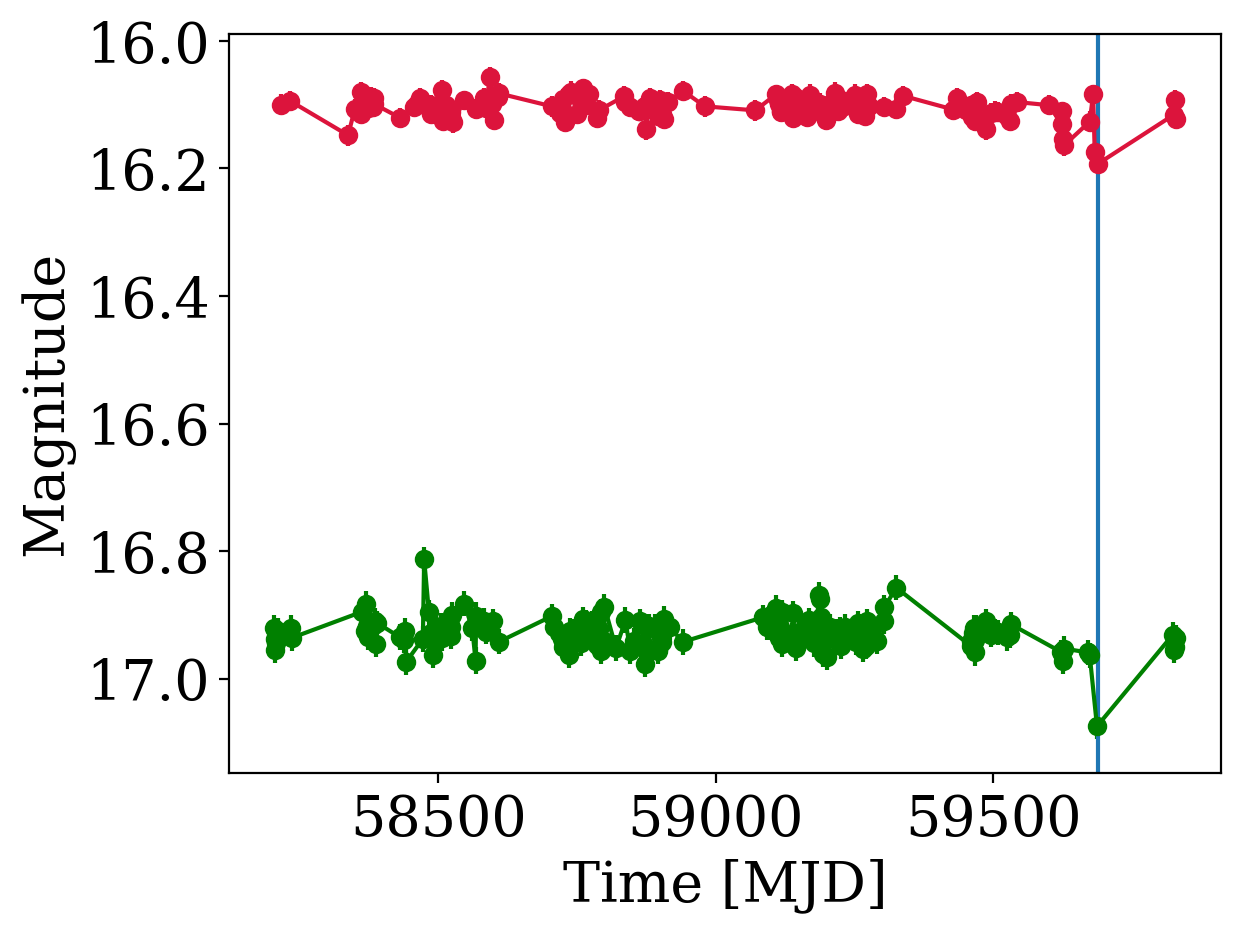

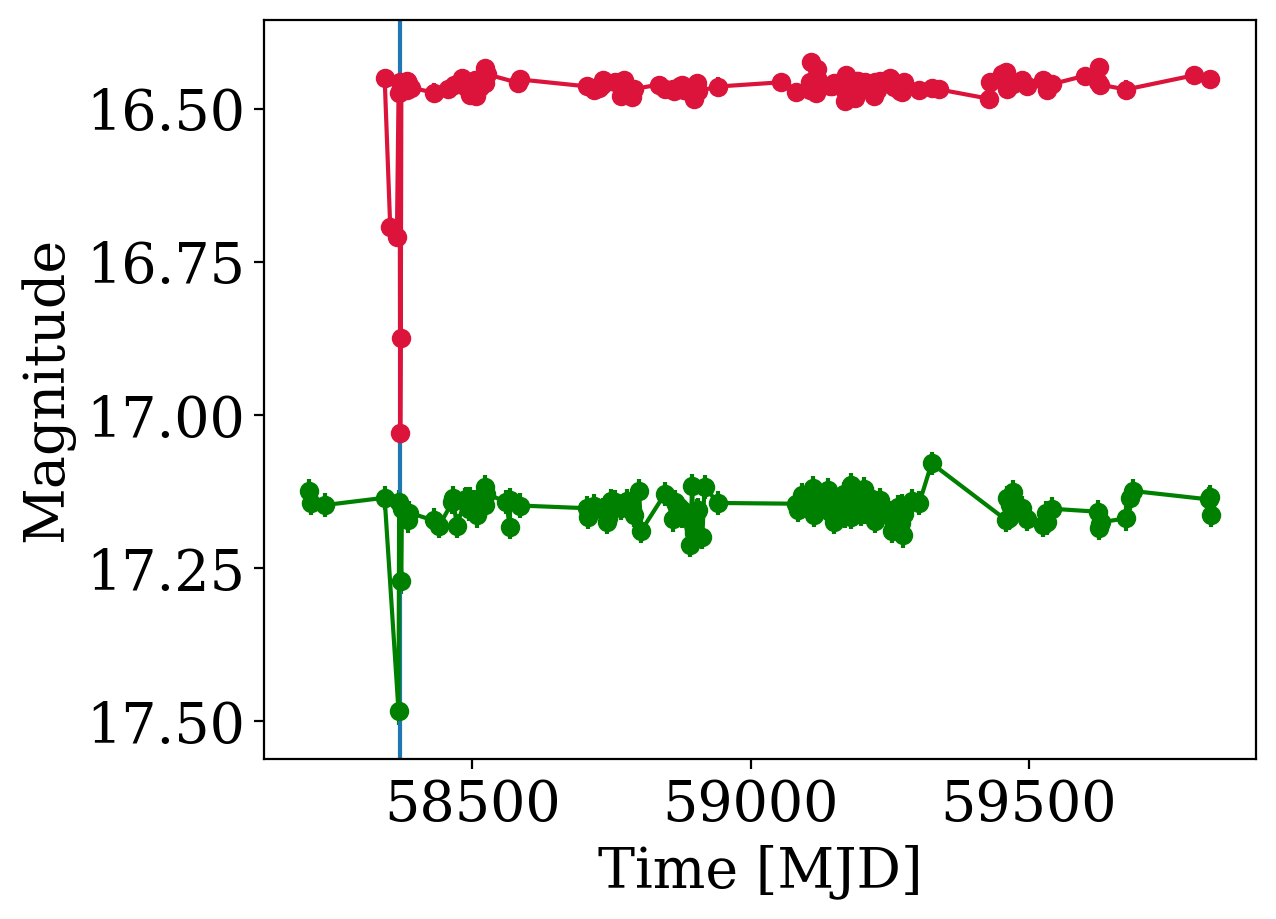

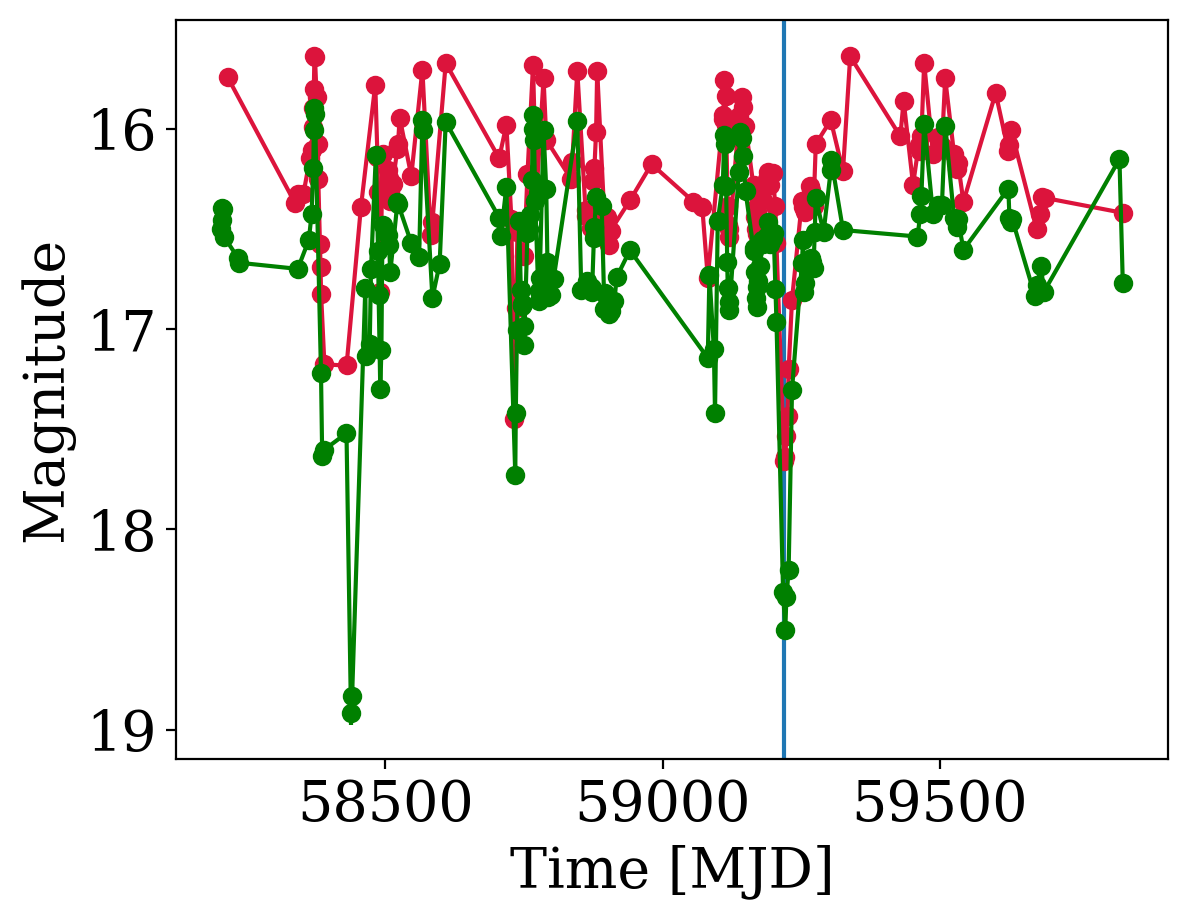

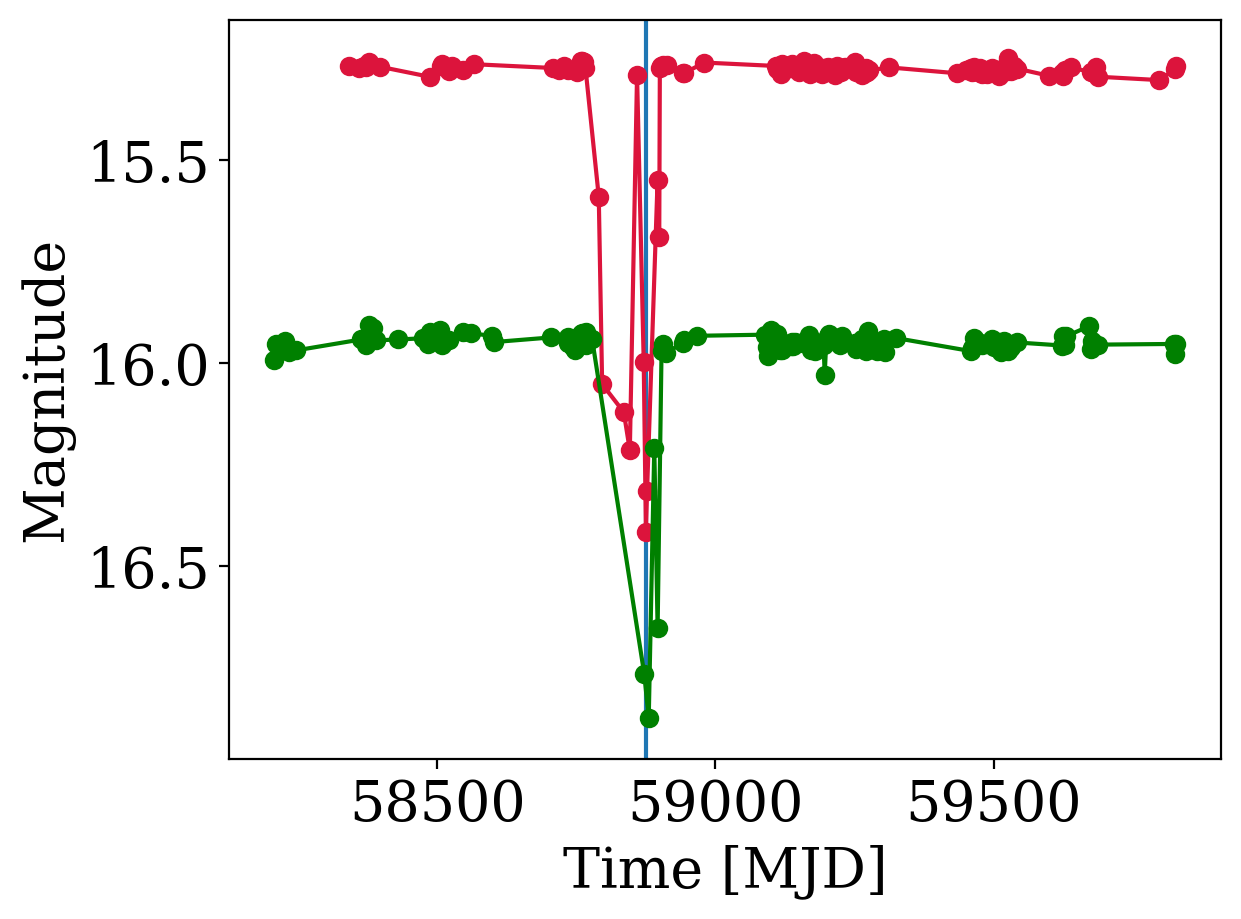

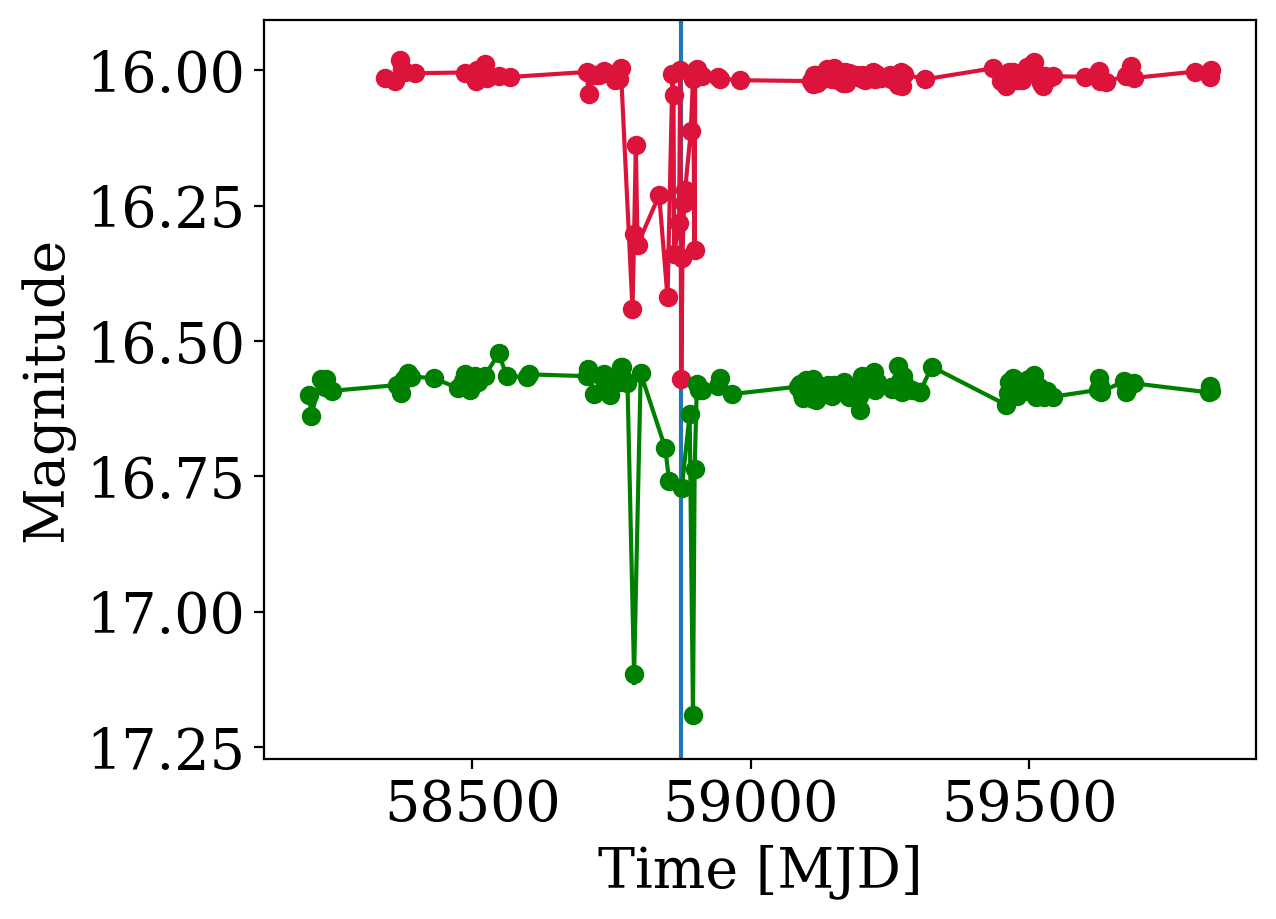

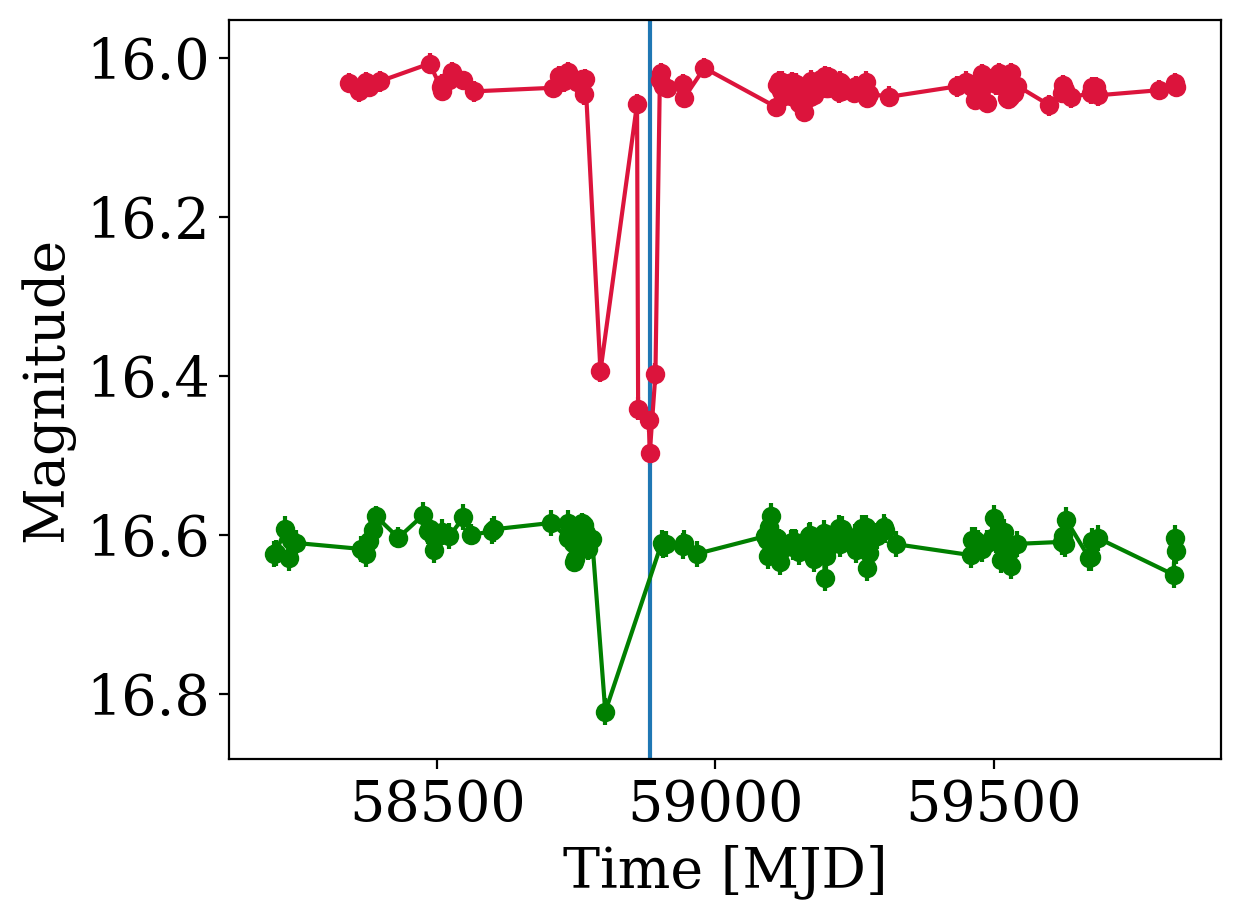

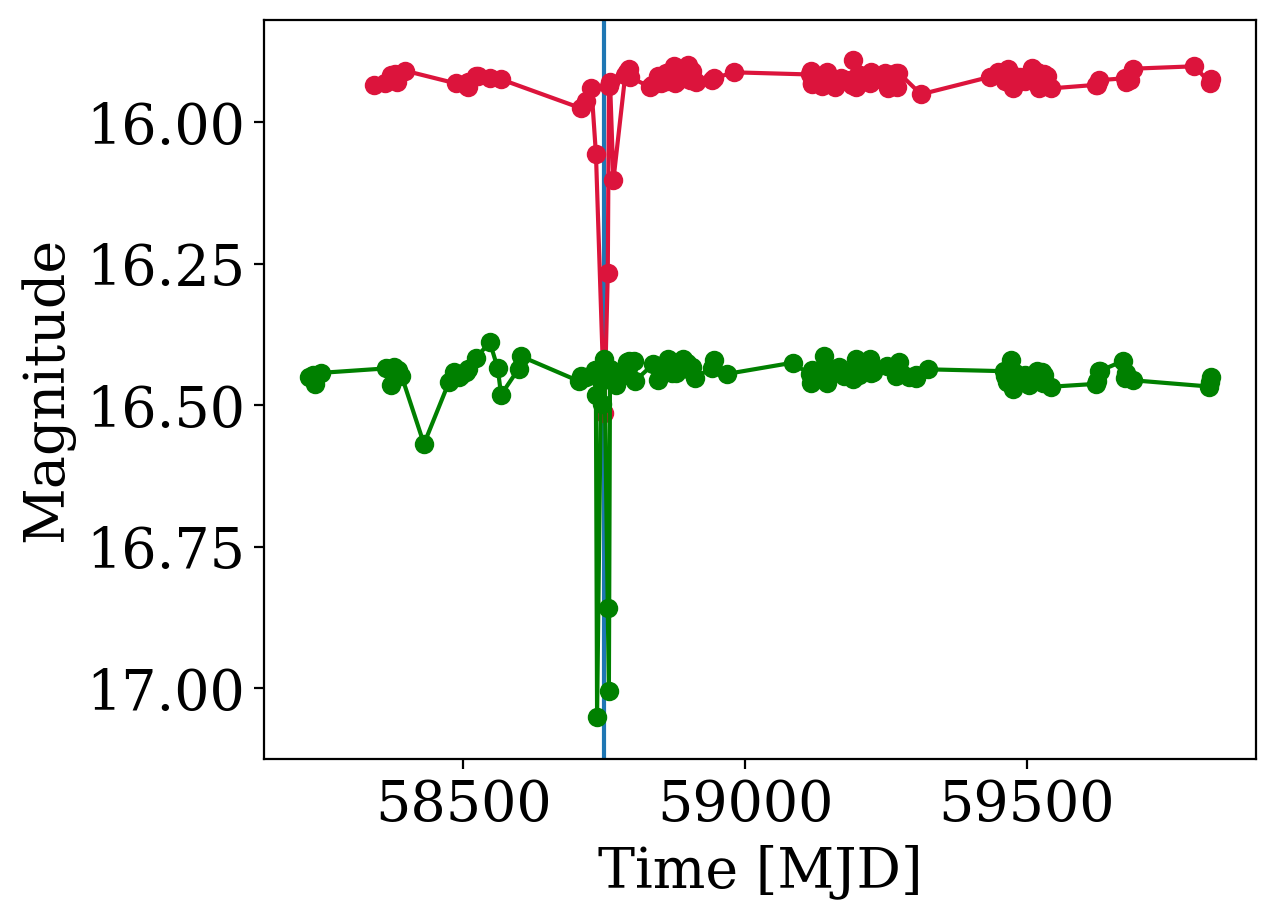

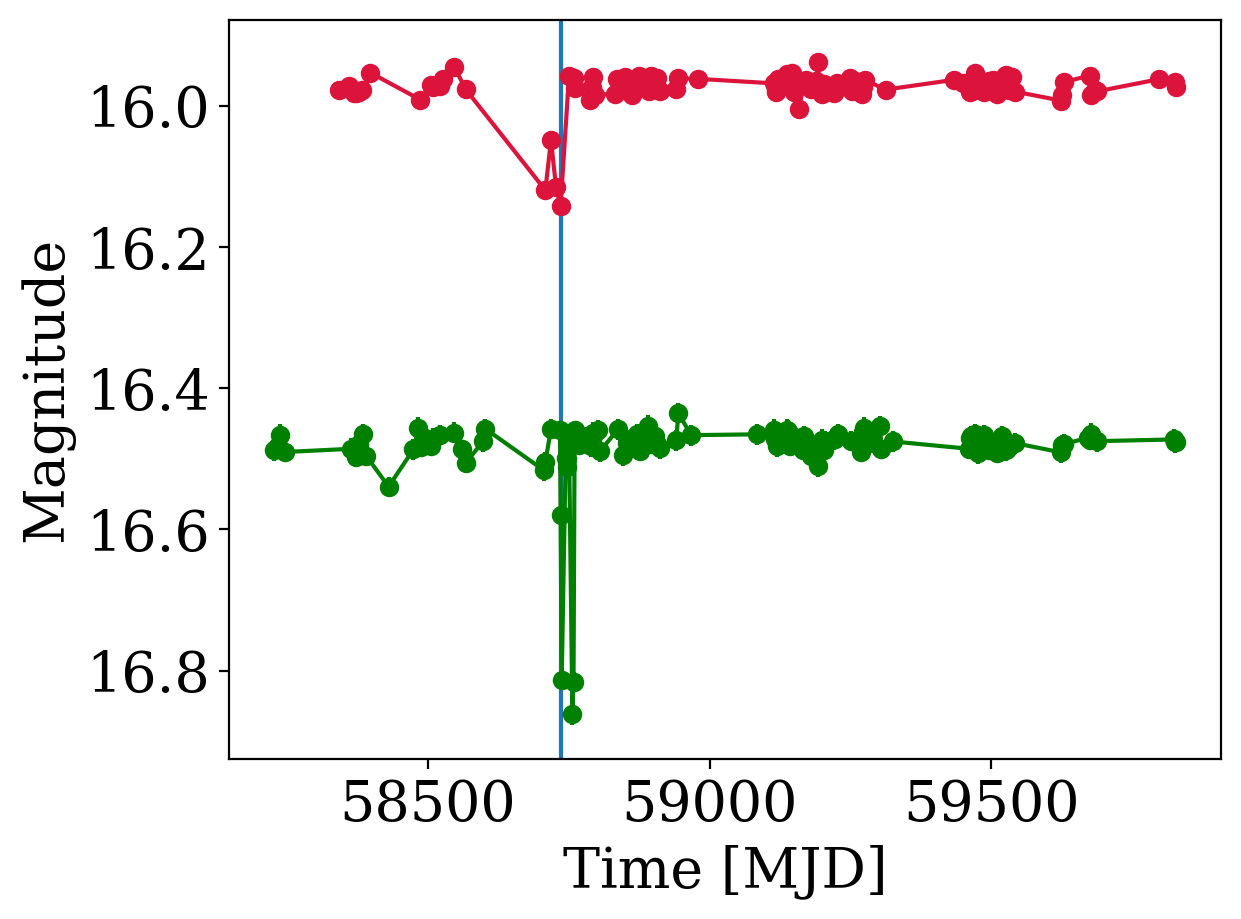

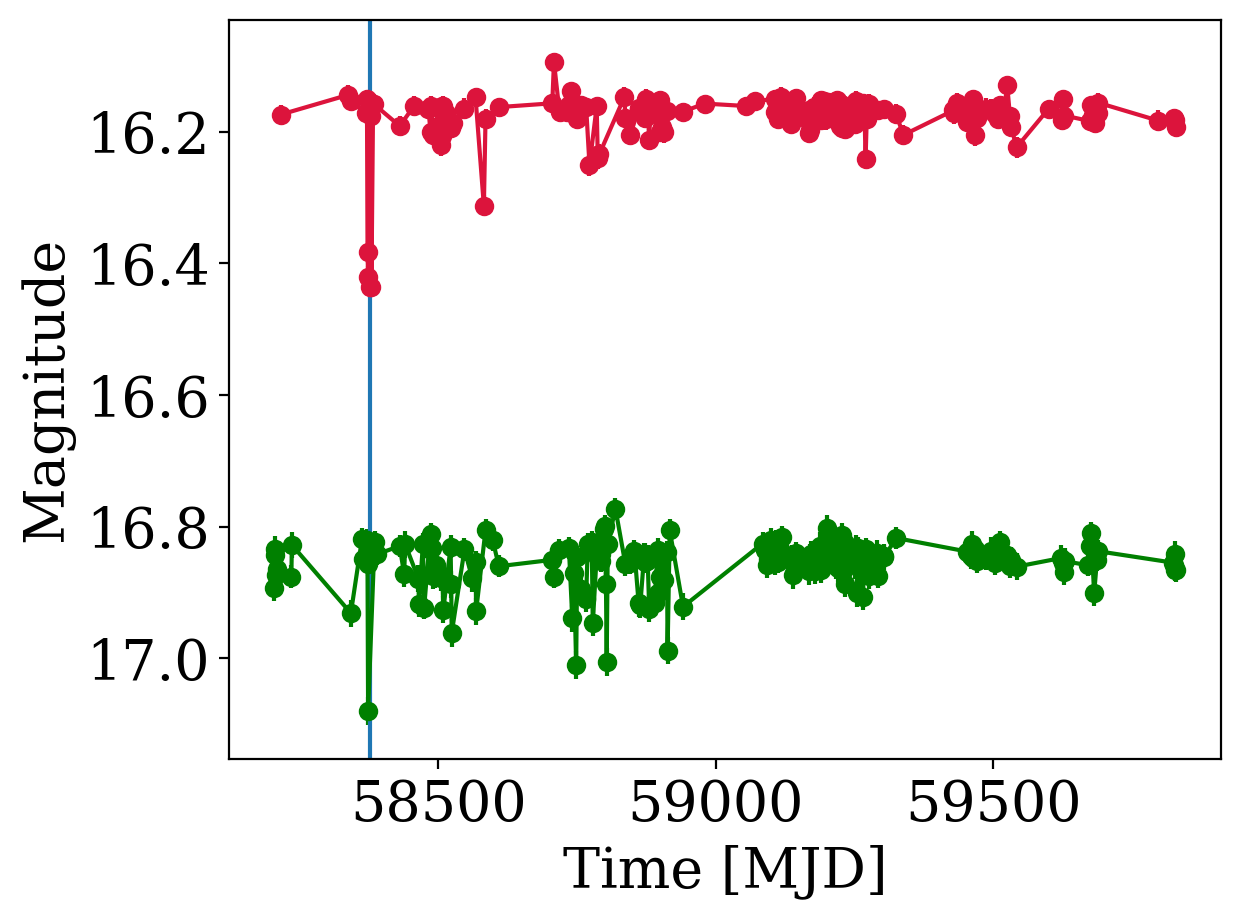

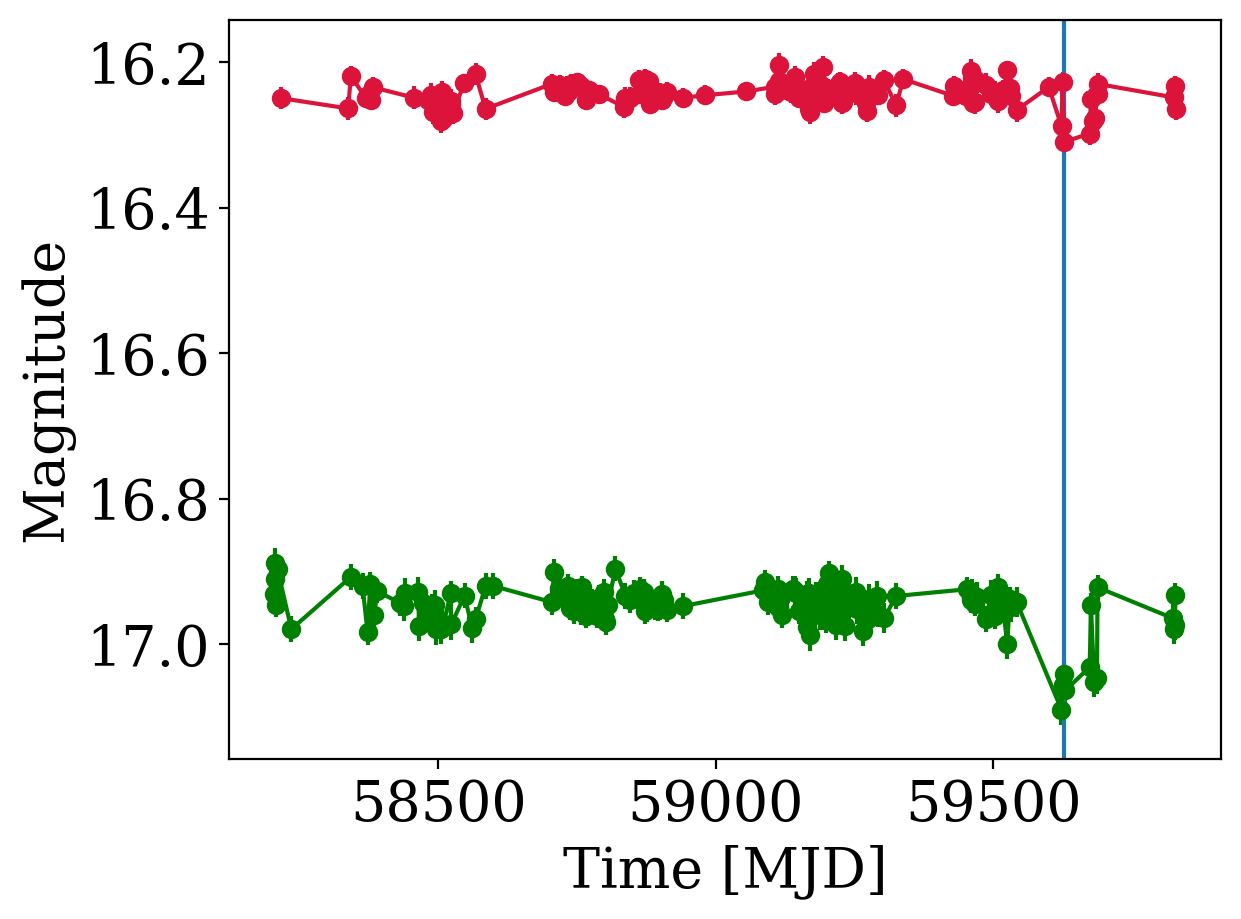

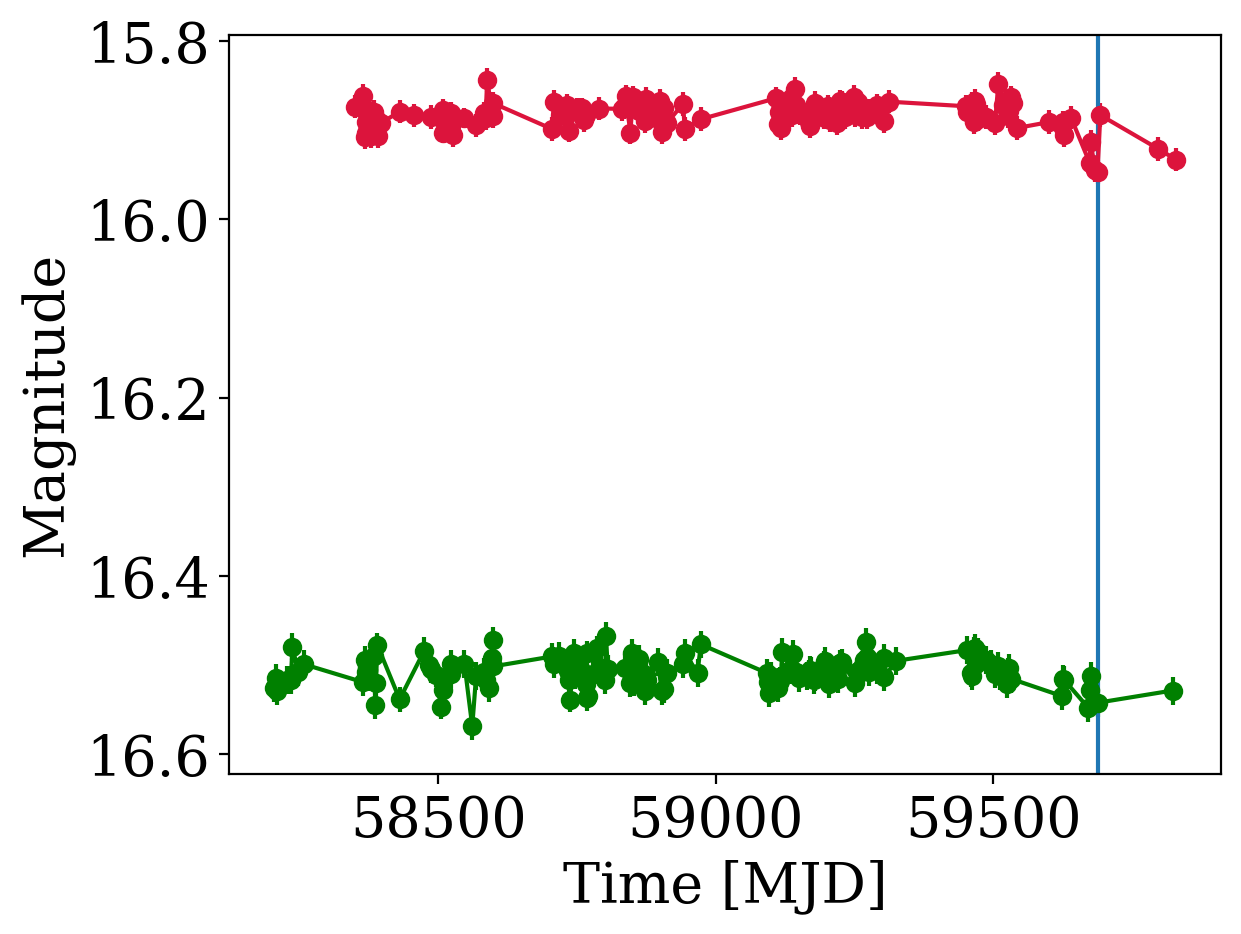

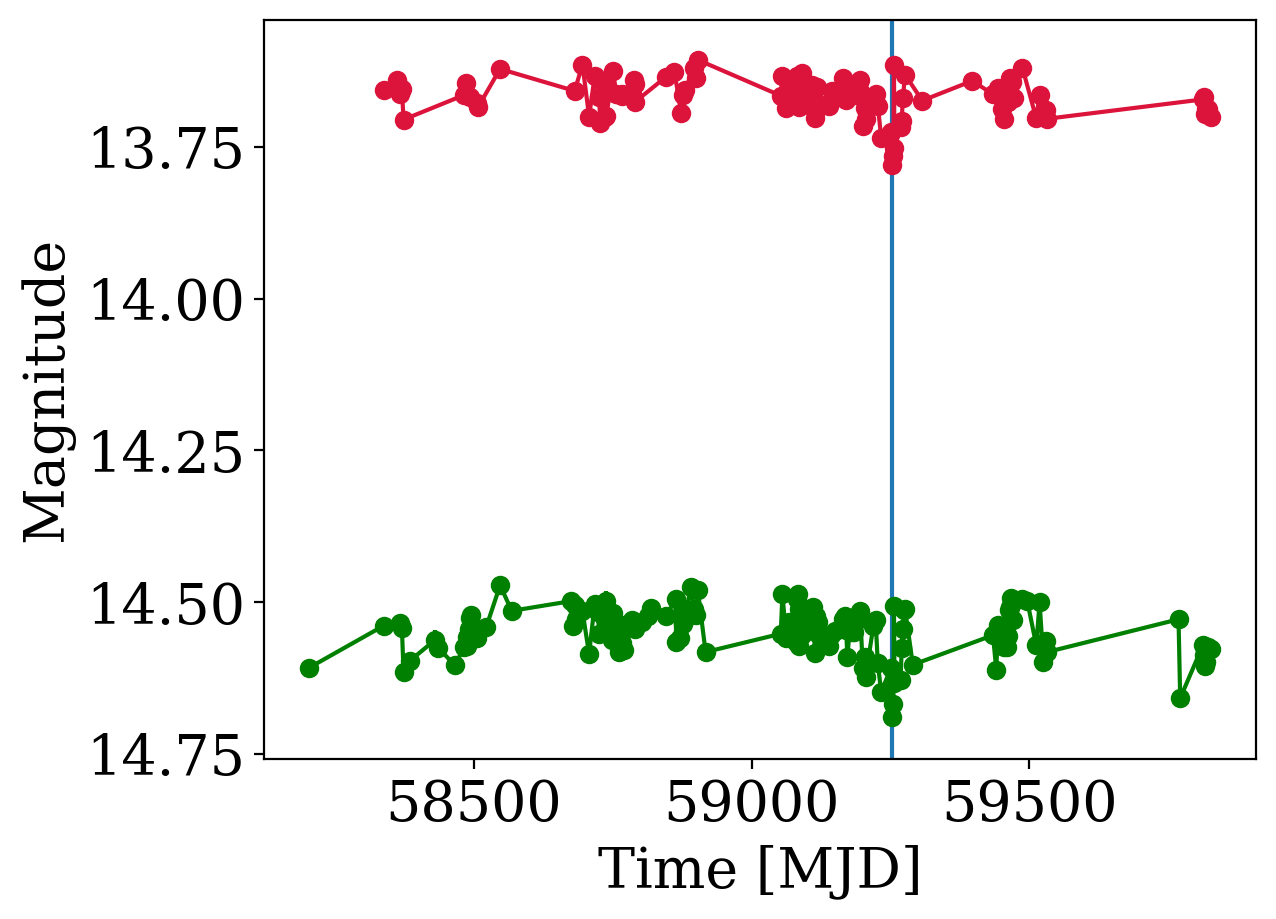

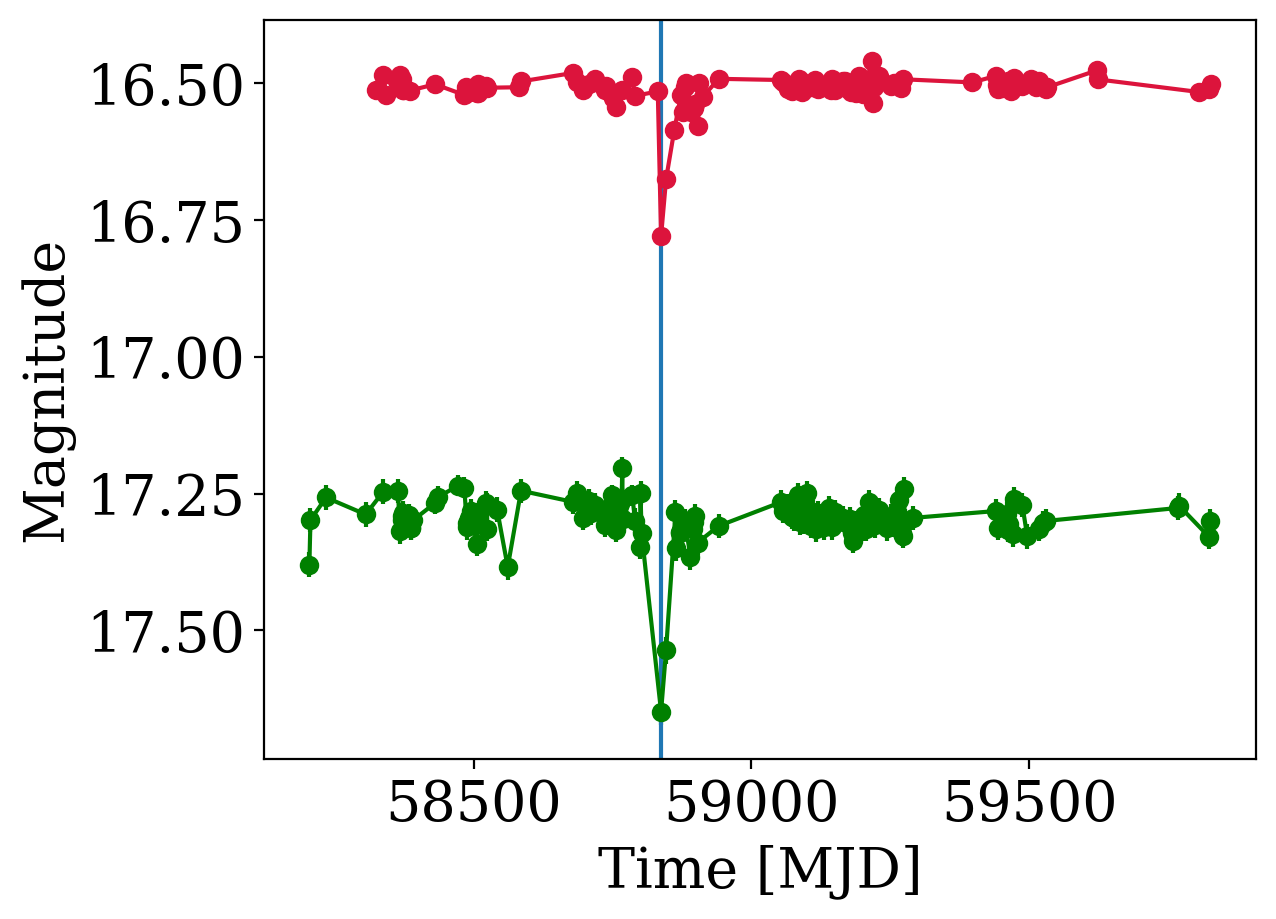

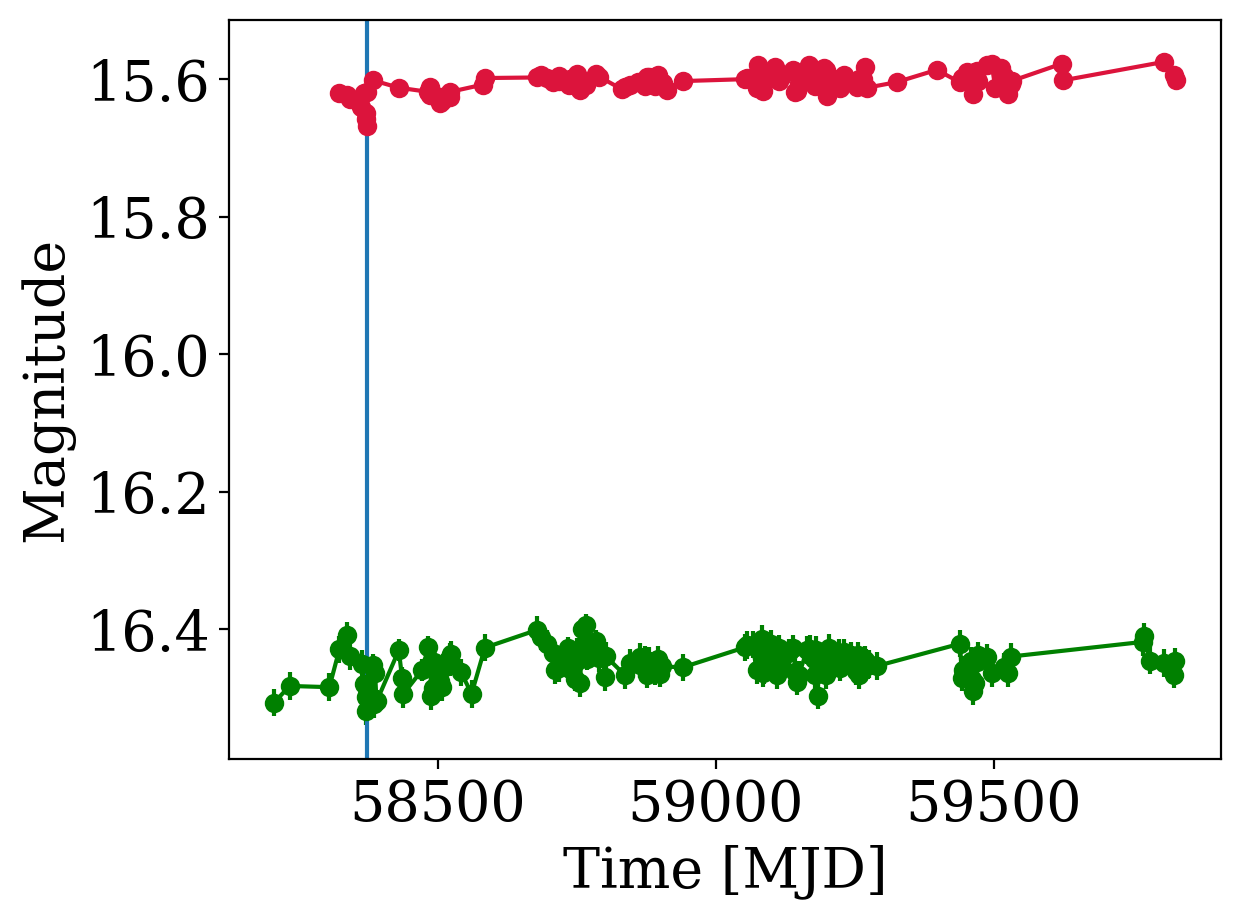

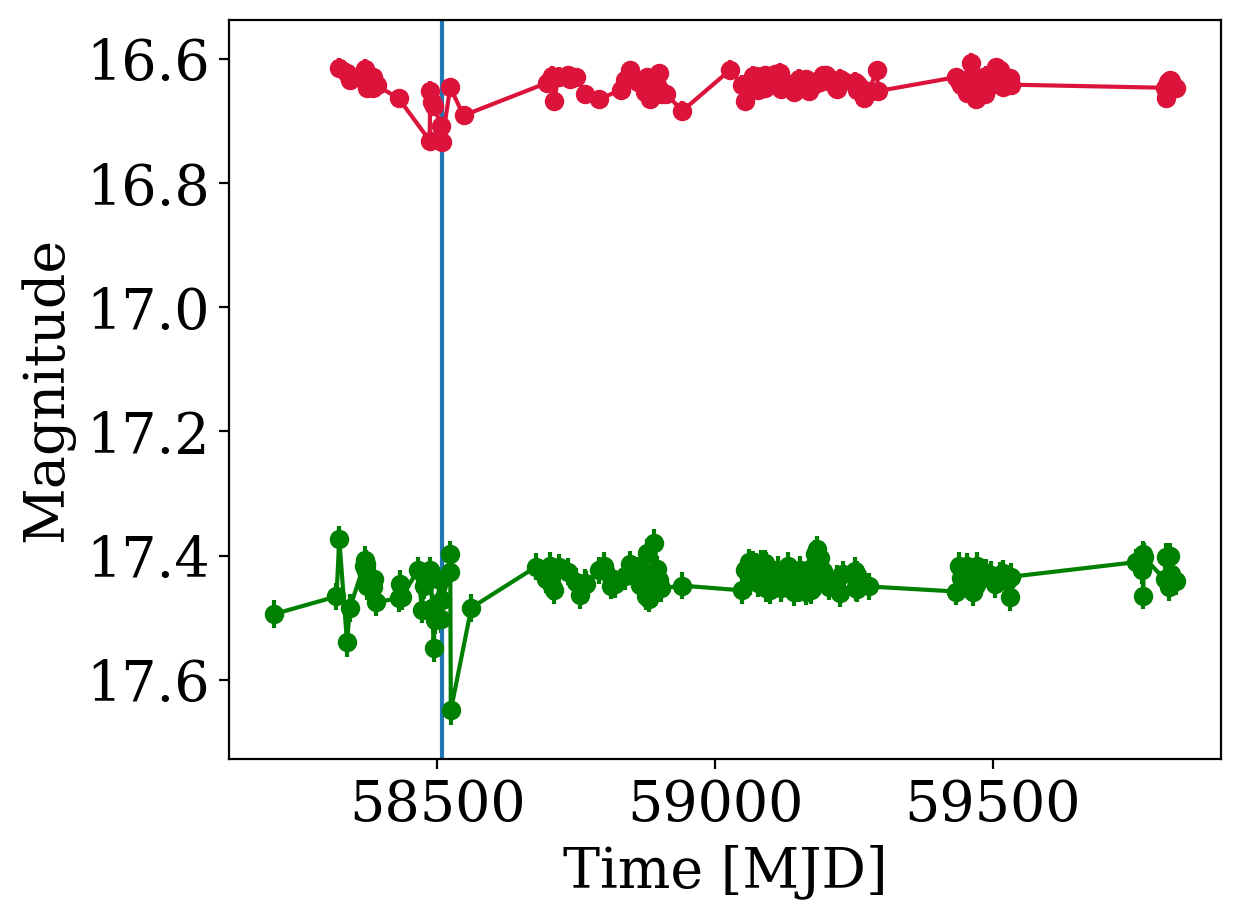

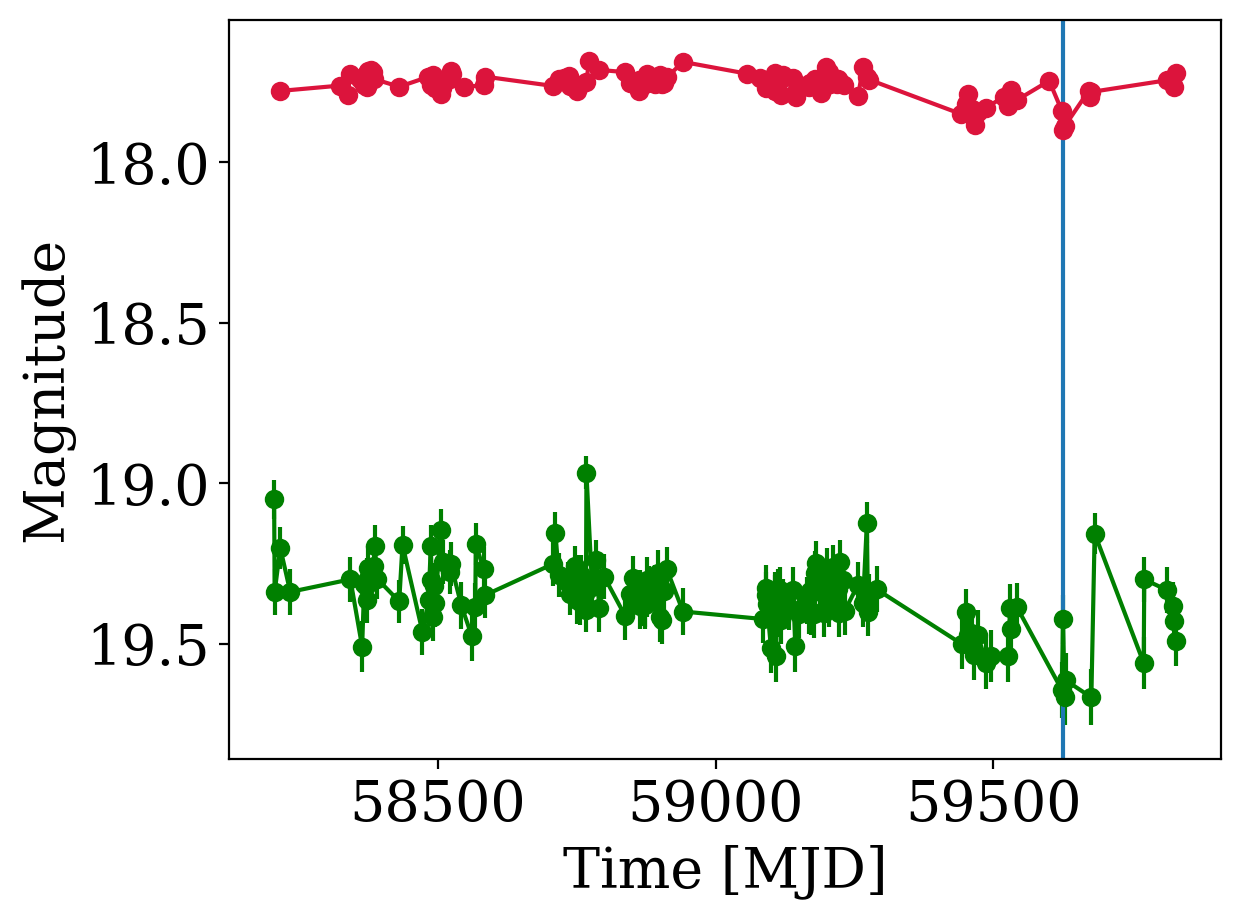

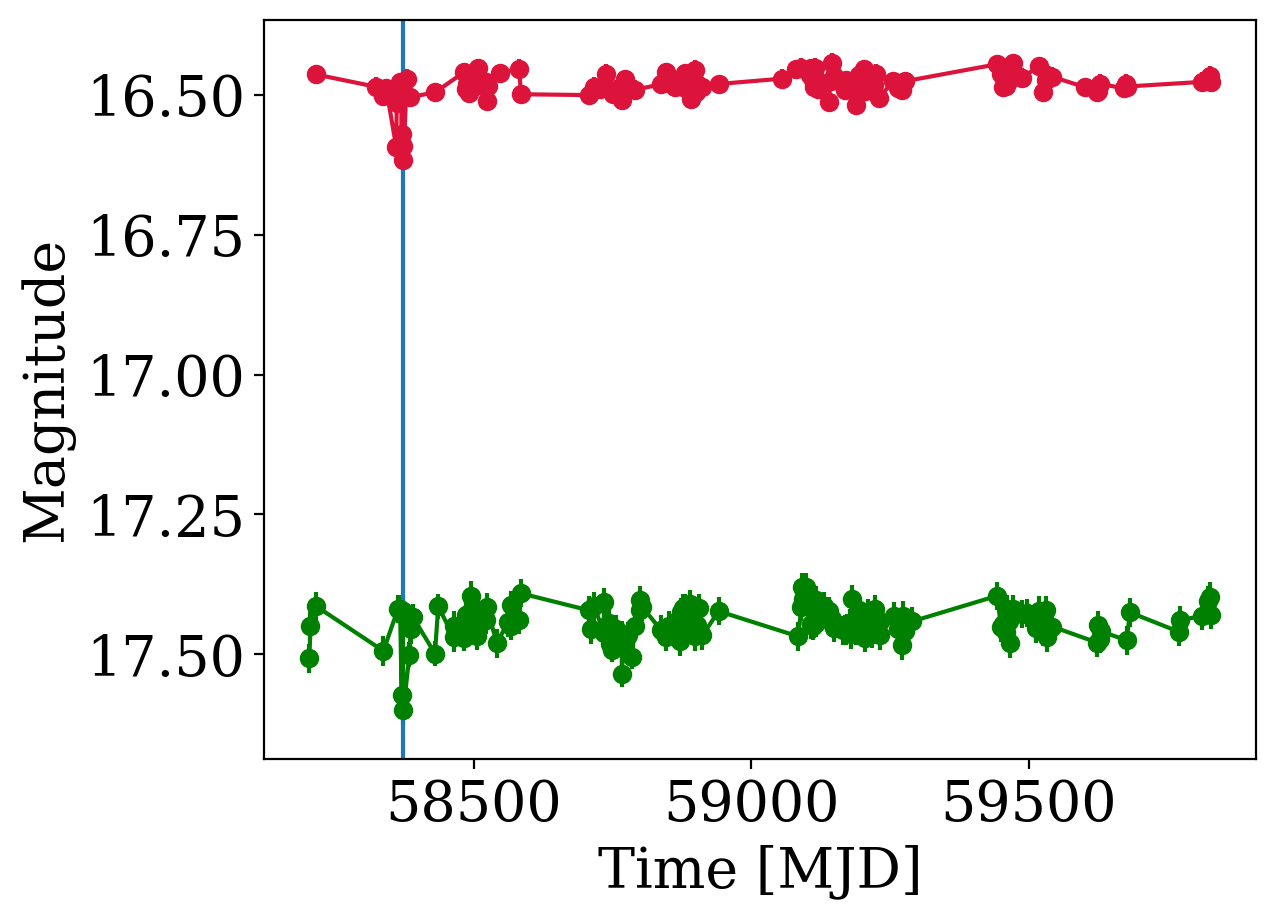

2024-02-08 17:47:36,095 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:36050'.
2024-02-08 17:47:36,099 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:36050'. Shutting down.


In [190]:
for i, j in tqdm(zip(demo_table[q]['best_dip_time_loc'], demo_table[q].index.values)):
    plot_lc(j, i)

In [153]:
demo_table[q].index.values

array([214833630155898880, 349501193262727168, 352191967087558656,
       366012772284104704, 375310573446889472, 377174417102340096,
       378624580723408896, 378629381460852736, 389296206100037632,
       391062914590572544, 393852297223864320, 393869823529975808,
       393891728140009472, 393999705748537344, 394003811724689408,
       394162237763223552, 394182263685775360], dtype=uint64)